In [1]:
import seaborn as sns
from ydata_synthetic.synthesizers.timeseries import TimeGAN
from ydata_synthetic.preprocessing.timeseries.utils import real_data_loading
import pandas as pd
import numpy as np
import os
import pickle
import sys
sys.path.insert(0, '../../data_process/')
sys.path.insert(1, '../')
from create_plots import *
from model_utility import ModelUtility
import params

2024-04-09 17:47:56.243930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 17:47:56.315468: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local//cuda-11.8/lib64
2024-04-09 17:47:56.315481: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-09 17:47:56.692871: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shar

In [2]:
def sumFeatureMetricsOfModels(models, data_metrics):
    '''
    Sums all column metrics (features) of a given model
    
    Args:
        models (dictionary): dictionary with model metrics
    
    Returns:
        Returns two lists of metric sums for 32-bit and 64-bit models. It is important to highlight that the positions
        in each of these lists store the sum of the metrics calculated for each of the model columns.
    '''
    sum32 = np.zeros(len(models))
    sum64 = np.zeros(len(models))

    for i in range(len(models)): 
            sum32[i] = sum(data_metrics[0,i,:])
            sum64[i] = sum(data_metrics[1,i,:])
            
    return sum32, sum64

In [3]:
def getModelNameByIndex(index):
    i, j, k = ModelUtility.defact(index, params.amount_of_models)
    model = 'so_seqlen_' + str((50*(i) + 50)) + '_hidim_'+str(20*(j)+20) + '_batch_'+str(28*(k)+100)+'.pkl'
    return model

In [4]:
def getFeaturesBestMetricsOfModels(models, metrics):
    '''
    Method called by the get_alfeatures_metrics method that effectively performs the calculation of equation 1 defined in the tutorial text.
    It is important to highlight that the lowest sum value indicates the best model while the highest value indicates the worst models. 
    That is, the lowest sum value indicates less variation between synthetic and real data, while the highest sum value indicates greater variation.
    
    Args:
        models (dictionary): Model dictionary where the key is the name of the trained model file and content is a list of two arrays
                             numpy, where the first element (index 0) stores the 32-bit model data and the second element (index 1)
                             stores 4-bit model data.
    
    Returns:
        Returns the synthetic data of the best and worst model trained for both buffer sizes: 32 and 64 bits

    '''
    sum32, sum64 = sumFeatureMetricsOfModels(models, metrics)
    
    index = np.argmin(sum32)
    model = getModelNameByIndex(index)
    #print('bestmodel_int32: ' + model + ' index: ' + str(index))
    best_32 = models.get(model)[0]
    
    index = np.argmin(sum64)
    model = getModelNameByIndex(index)
    #print('bestmodel_int64: ' + model + ' index: ' + str(index))
    best_64 = models.get(model)[0]
    
    index = np.argmax(sum32)
    model = getModelNameByIndex(index)
    #print('worst_int32: ' + model + ' index: ' + str(index))
    worst_32 = models.get(model)[0]
    
    index = np.argmax(sum64)
    model = getModelNameByIndex(index)
    #print('worst_int32: ' + model + ' index: ' + str(index))
    worst_64 = models.get(model)[0]

    
    return best_32, worst_32, best_64, worst_64

In [6]:
def createRealDataSet(models_config, filename, data, num_cols):
    synthetic_df = pd.DataFrame(columns=num_cols)
    for j, col in enumerate(num_cols): 
            synthetic_df[col] = data[:,j]
    
    os.makedirs('../synth_ds/' + models_config + '/', exist_ok=True) 
    synthetic_df.to_csv('../synth_ds/' + models_config + '/' + filename + '.csv', index=False)
    
    return synthetic_df

In [7]:
def createSaveDataSetModel(models_obj, filename, model, num_cols, ordered):
    '''
    Saves data from a synthetic dataset to a .csv file
    
    Args:
        models_obj (string): defines the name of the folder within the synth_ds folder that will store the generated .csv file.
        filename (string): name of the .csv file that will be generated 
        model (numpy array): array with the synthetic data of a given model
        num_cols (list): list of columns (features) that you want to save in the .csv file
        ordered: True case if you want to sort the dataset by the buffer column. You can change the sort column by changing 
                 the by parameter in sort_values.
    
    Returns:
        Returns a data frame.

    '''
    synthetic_df = pd.DataFrame(columns=num_cols)
    for j, col in enumerate(num_cols): 
        synthetic_df[col] = model[:,j]
    
    if(ordered == True):
        synthetic_df = synthetic_df.sort_values(by=["Buffer"],ignore_index=True)
    
    os.makedirs('../synth_ds/' + models_obj + '/', exist_ok=True) 
    synthetic_df.to_csv('../synth_ds/' + models_obj + '/' + filename + '.csv', index=False)
    
    return synthetic_df

####################### LOAD DATA #######################

In [8]:
# Loading data objects from saved
sample_size = params.statistic_sample_size

realdata_obj = params.realdata_obj
models_obj = params.models_obj
metrics_obj= params.metrics_obj

num_cols = params.num_cols
cat_cols = params.cat_cols

metrics = np.zeros(2*params.amount_of_models*len(num_cols)).reshape(2,params.amount_of_models,len(num_cols))

with open('../saved_objects/' + metrics_obj, 'rb') as file:
        # Load the object from the file
        metrics = pickle.load(file)
        
with open('../saved_objects/' + models_obj, 'rb') as file:
        # Load the object from the file
        models = pickle.load(file)

with open('../saved_objects/' + realdata_obj, 'rb') as file:
        # Load the object from the file
        real_data = pickle.load(file)

In [9]:
real_32 = real_data[0]
real_64 = real_data[1]

In [10]:
# Select best and worst feature using the metric explained in the paper
best_modelsum_32, worst_modelsum_32, best_modelsum_64, worst_modelsum_64 = getFeaturesBestMetricsOfModels(models, metrics)

bestmodel_int32: so_seqlen_50_hidim_20_batch_100.pkl index: 0
bestmodel_int64: so_seqlen_50_hidim_20_batch_100.pkl index: 0
worst_int32: so_seqlen_50_hidim_20_batch_156.pkl index: 2
worst_int32: so_seqlen_50_hidim_20_batch_156.pkl index: 2


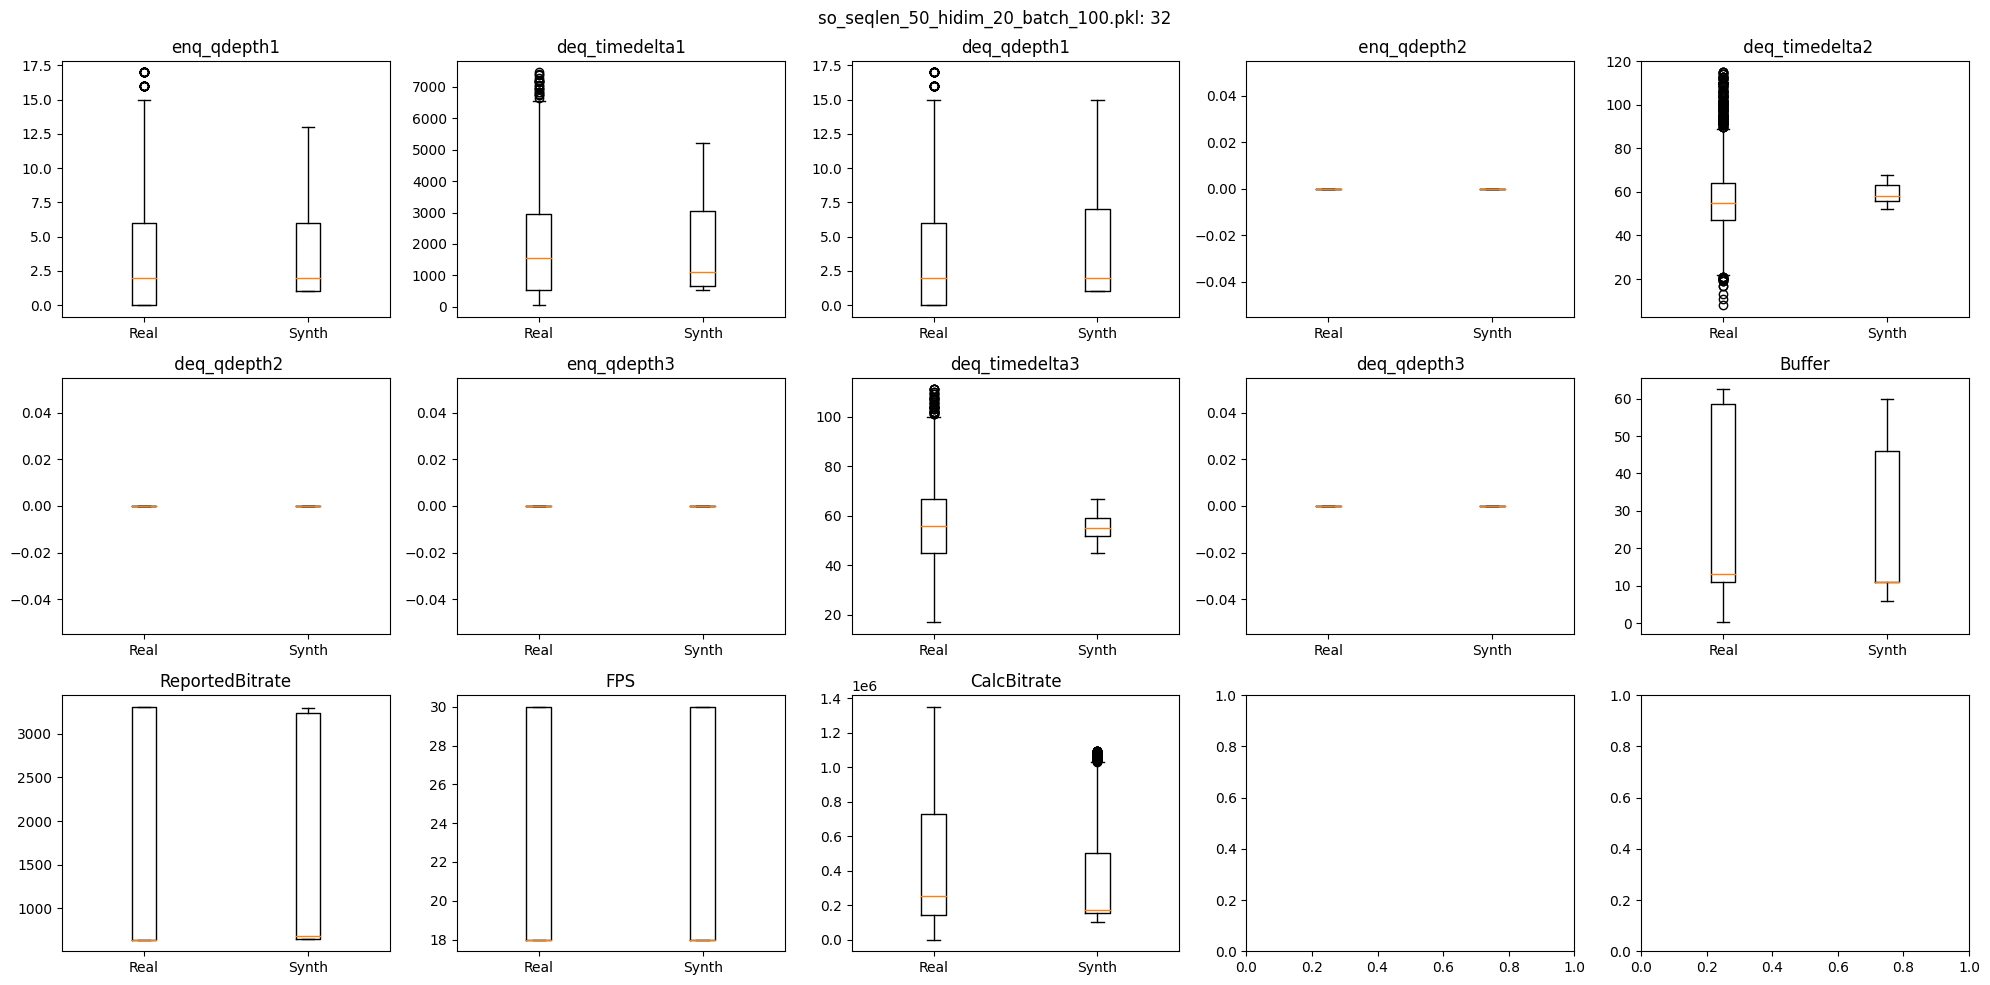

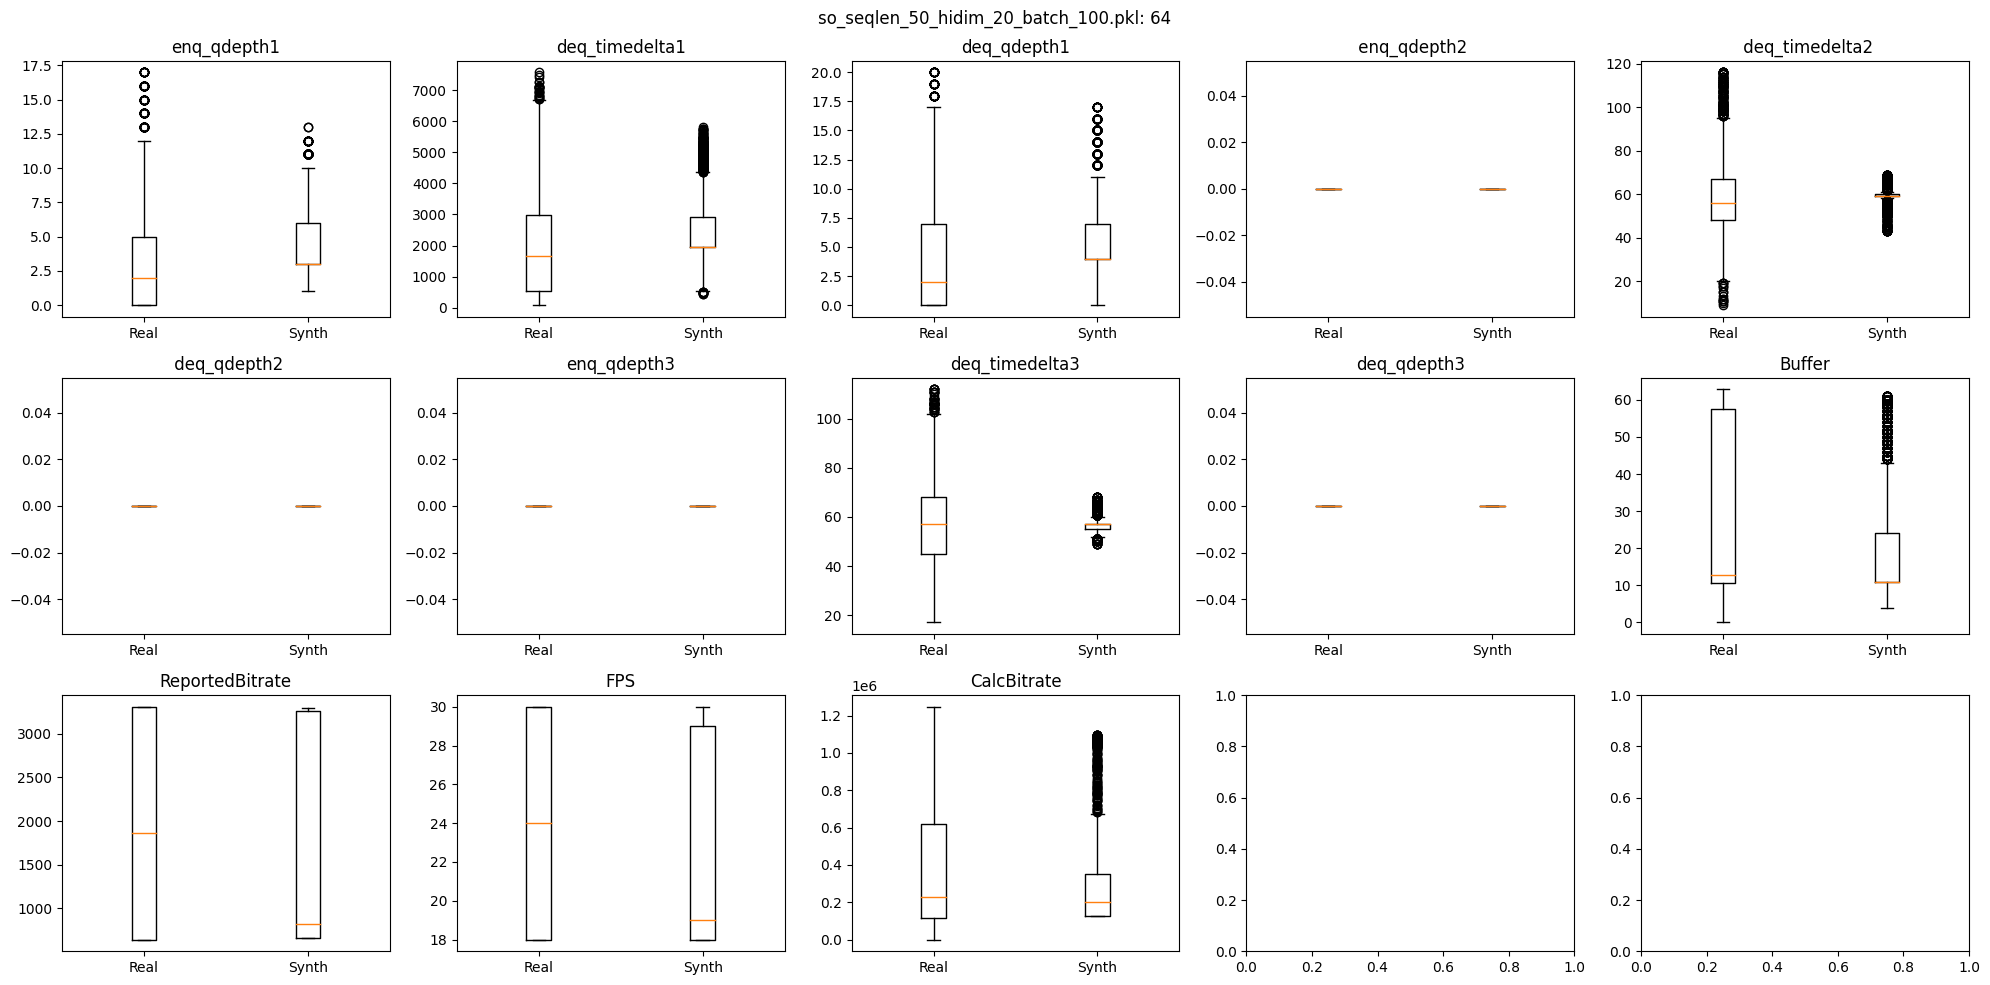

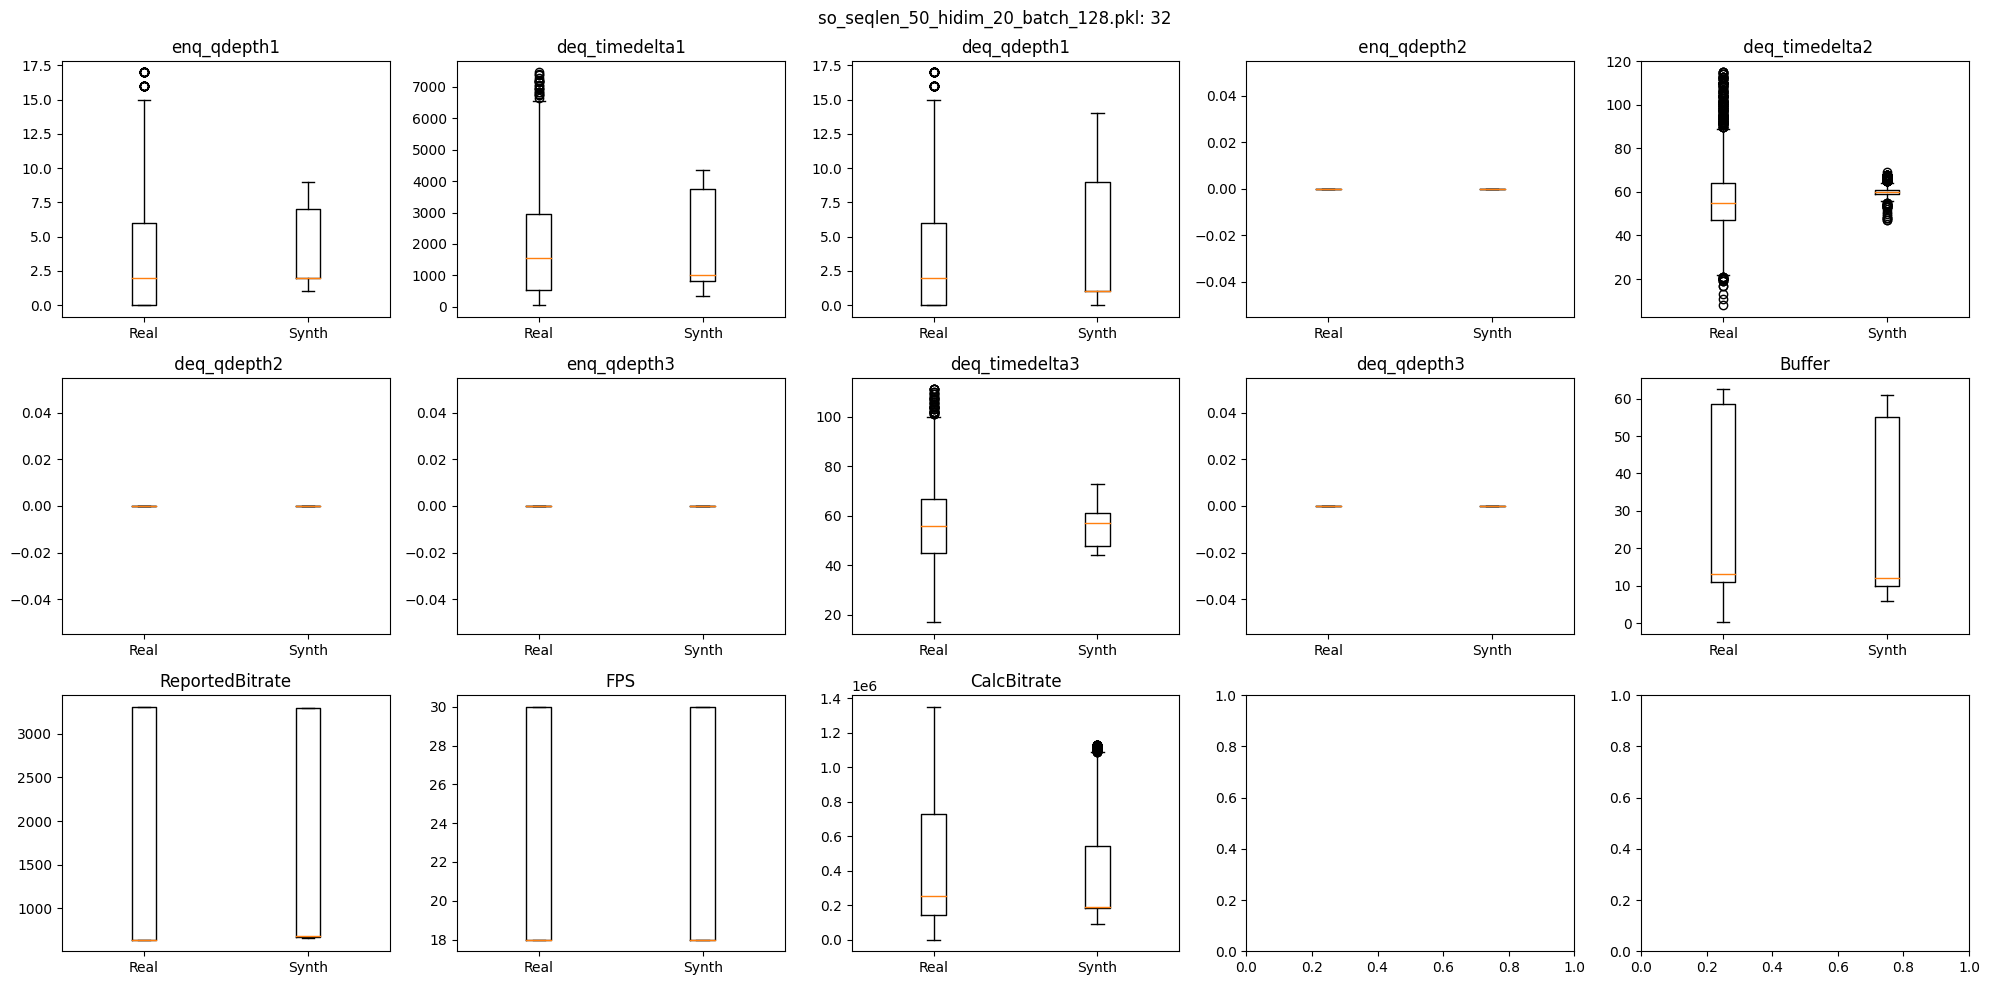

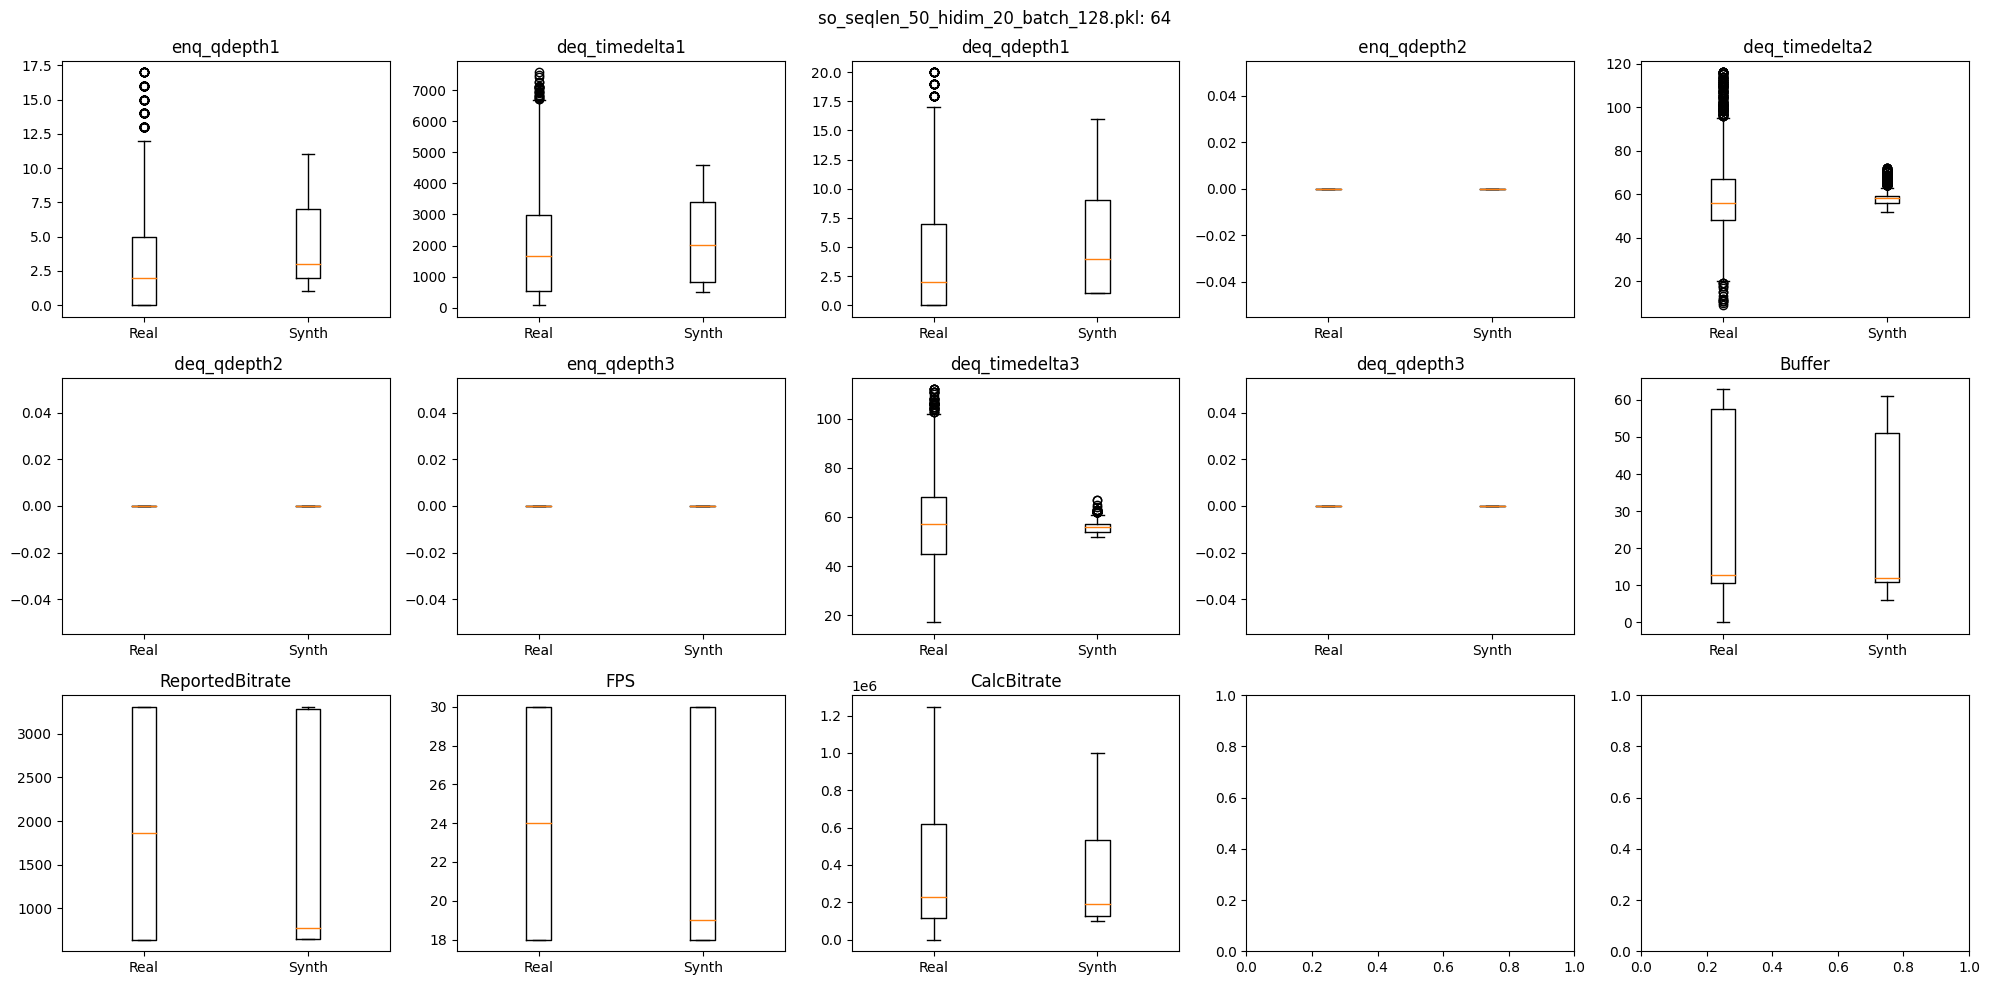

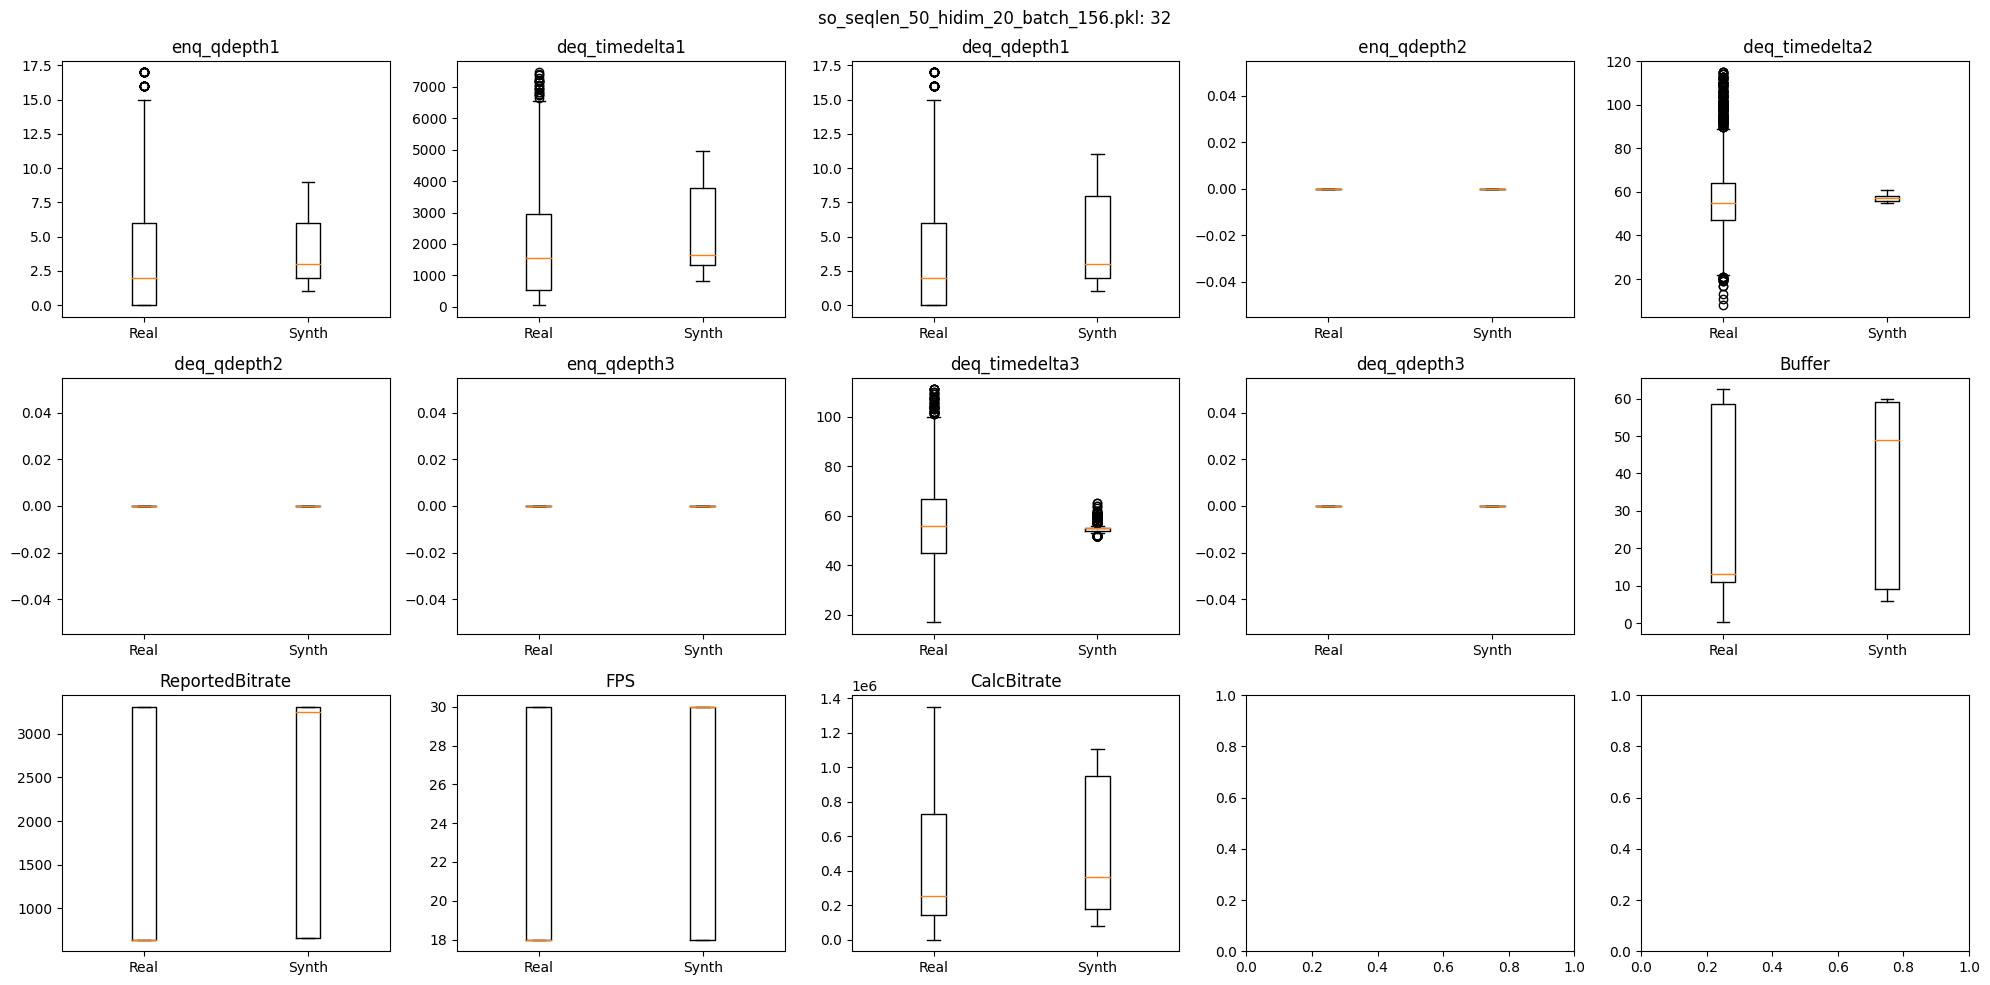

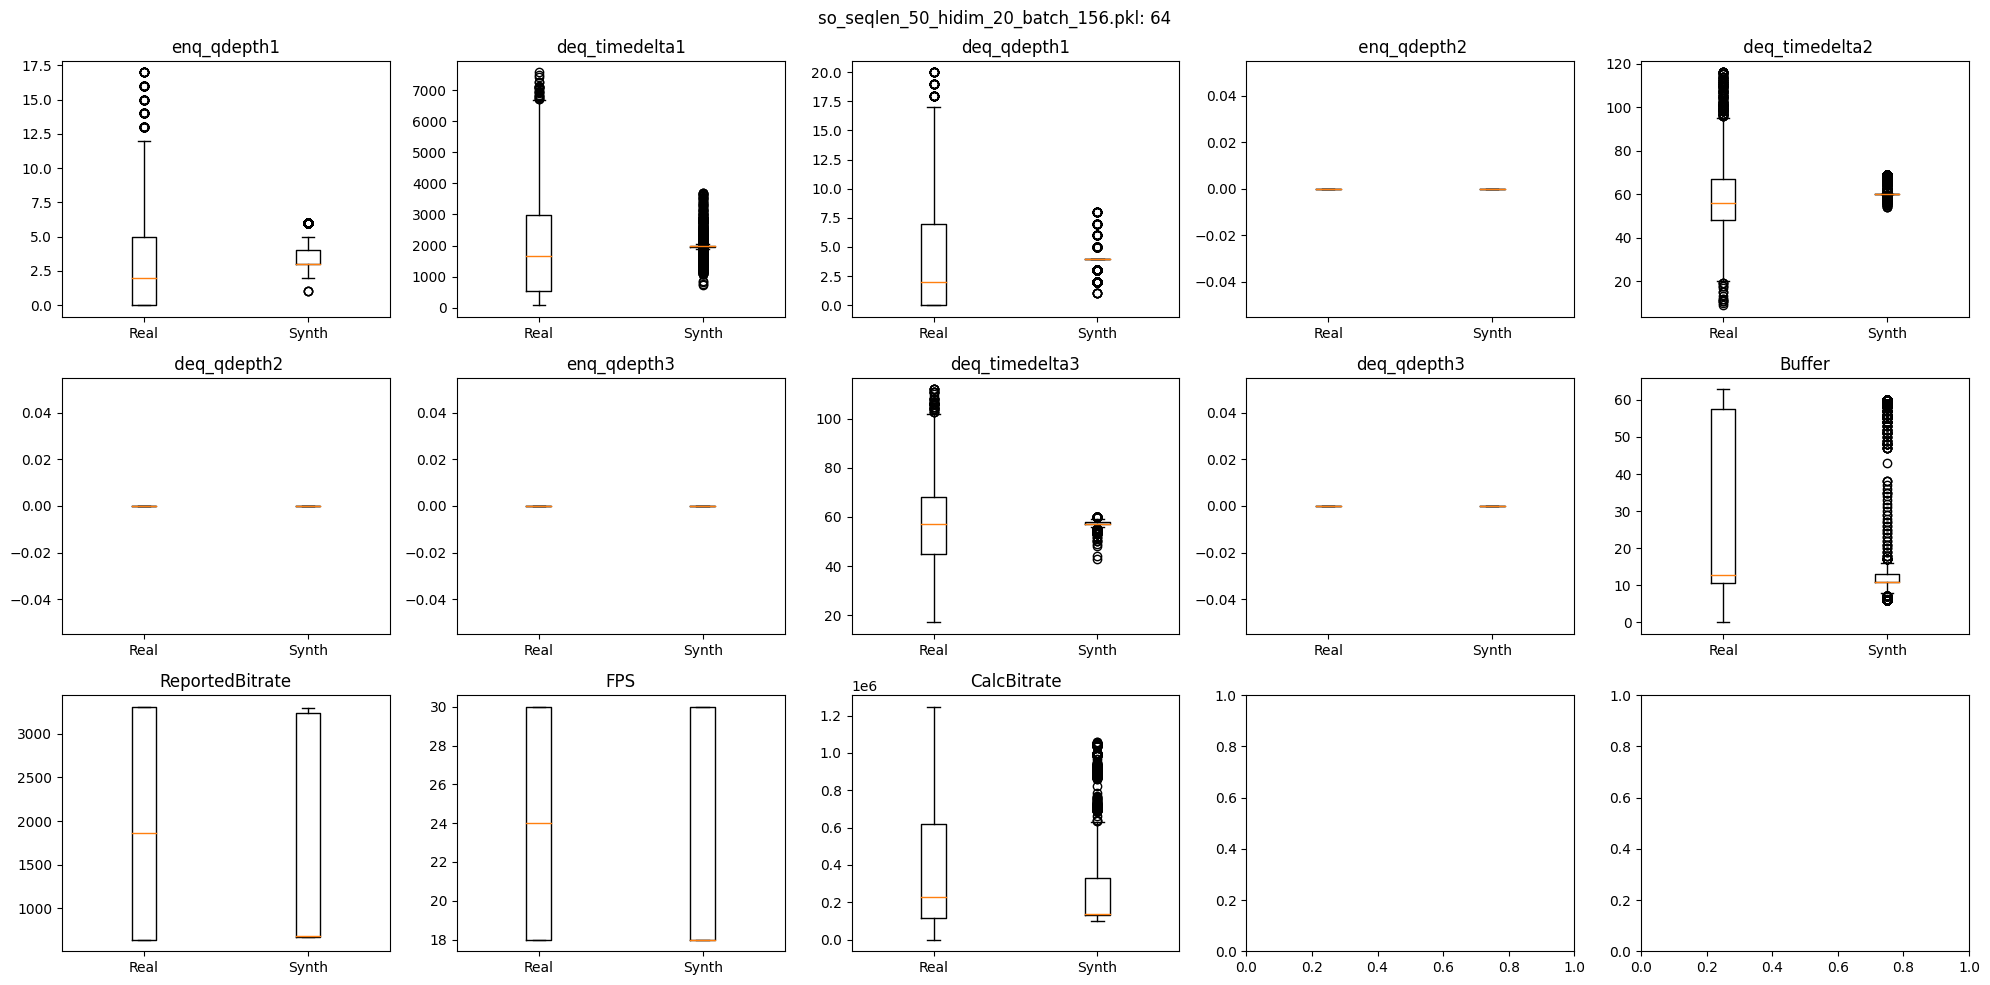

In [9]:
#Uncomment this code if you want to see the feature distributions of all models
iMax, jMax, kMax = ModelUtility.fatNum(params.amount_of_models) 
for i in range(0,1):
    for j in range(0,1):
        for k in range(0,3):
           model = 'so_seqlen_'+str((50*(i) + 50))+'_hidim_'+str(20*(j)+20)+'_batch_'+str(28*(k)+100)+'.pkl'
           synth32 = models.get(model)[0]
           synth64 = models.get(model)[1]
           genBoxPlotAllFeatures(models_obj, model + ': 32', real_32, synth32, sample_size, num_cols, save=False, file_name= '')
           genBoxPlotAllFeatures(models_obj, model + ': 64', real_64, synth64, sample_size, num_cols, save=False, file_name= '') 

######### BOX PLOT  ##########

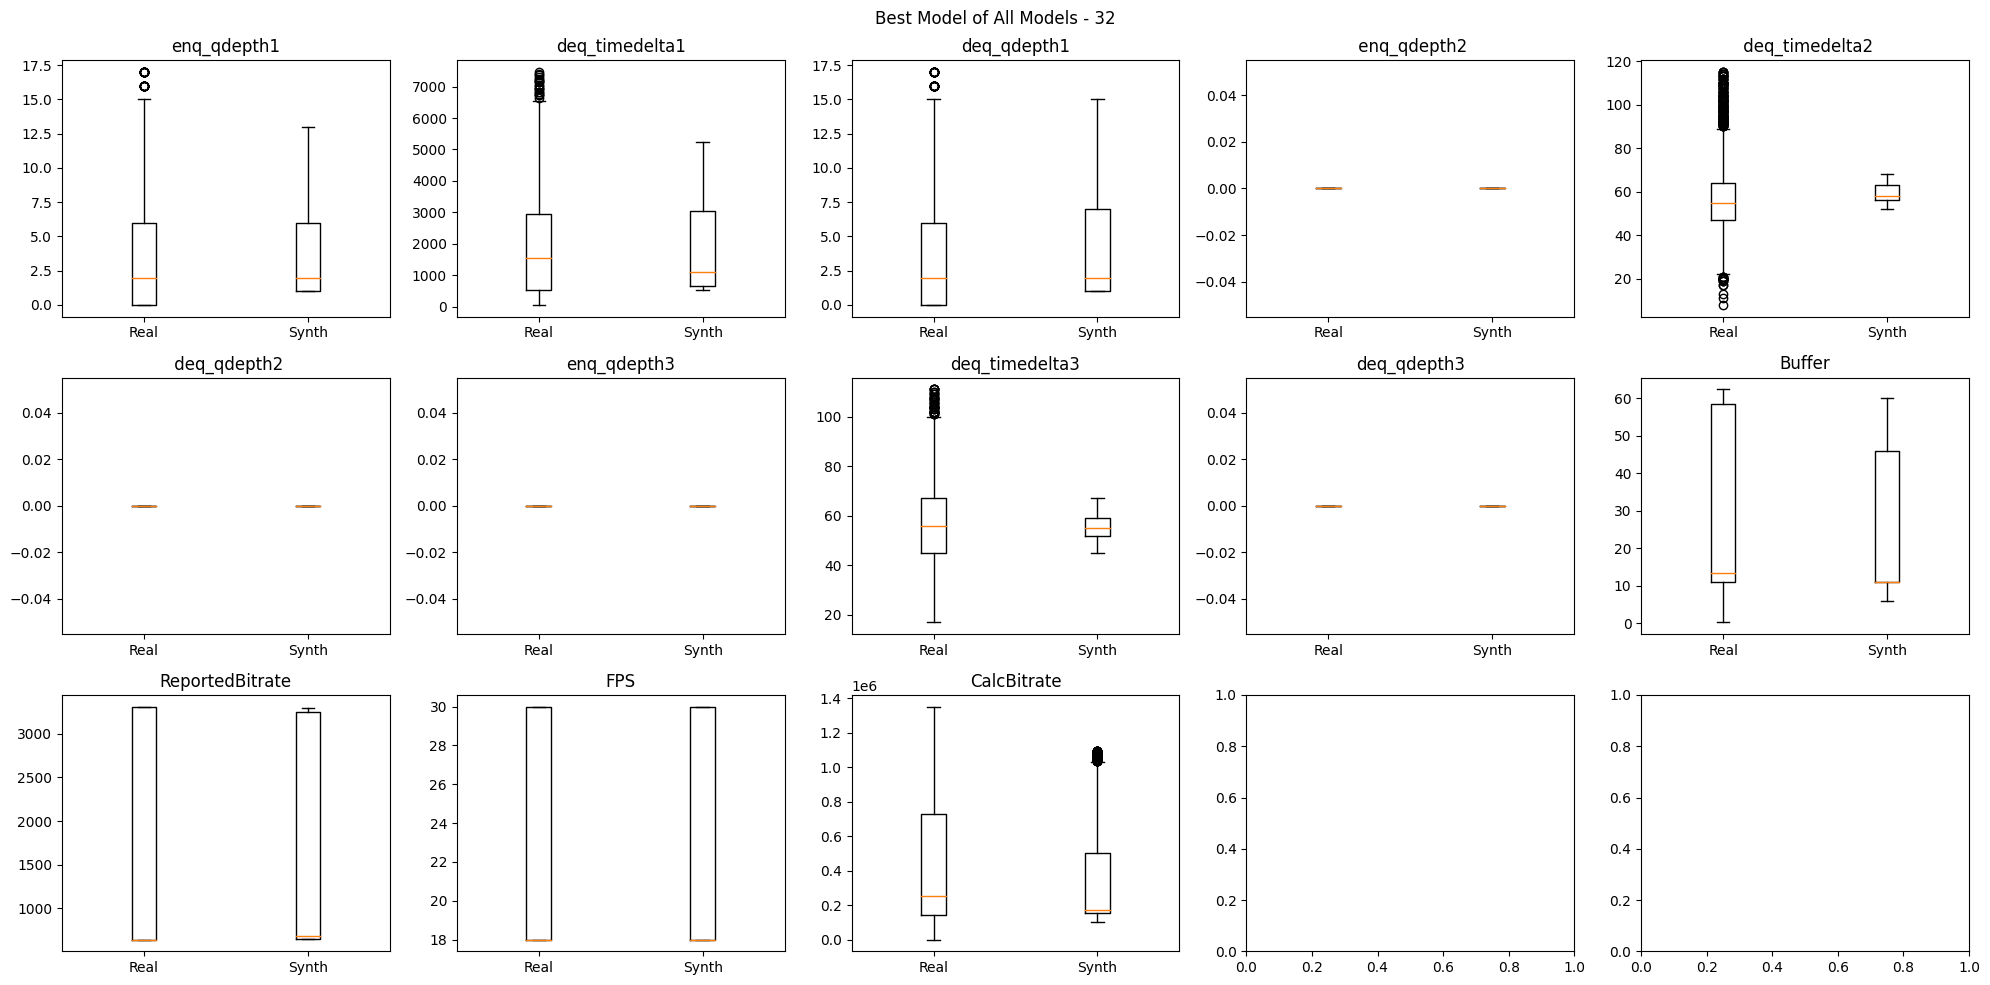

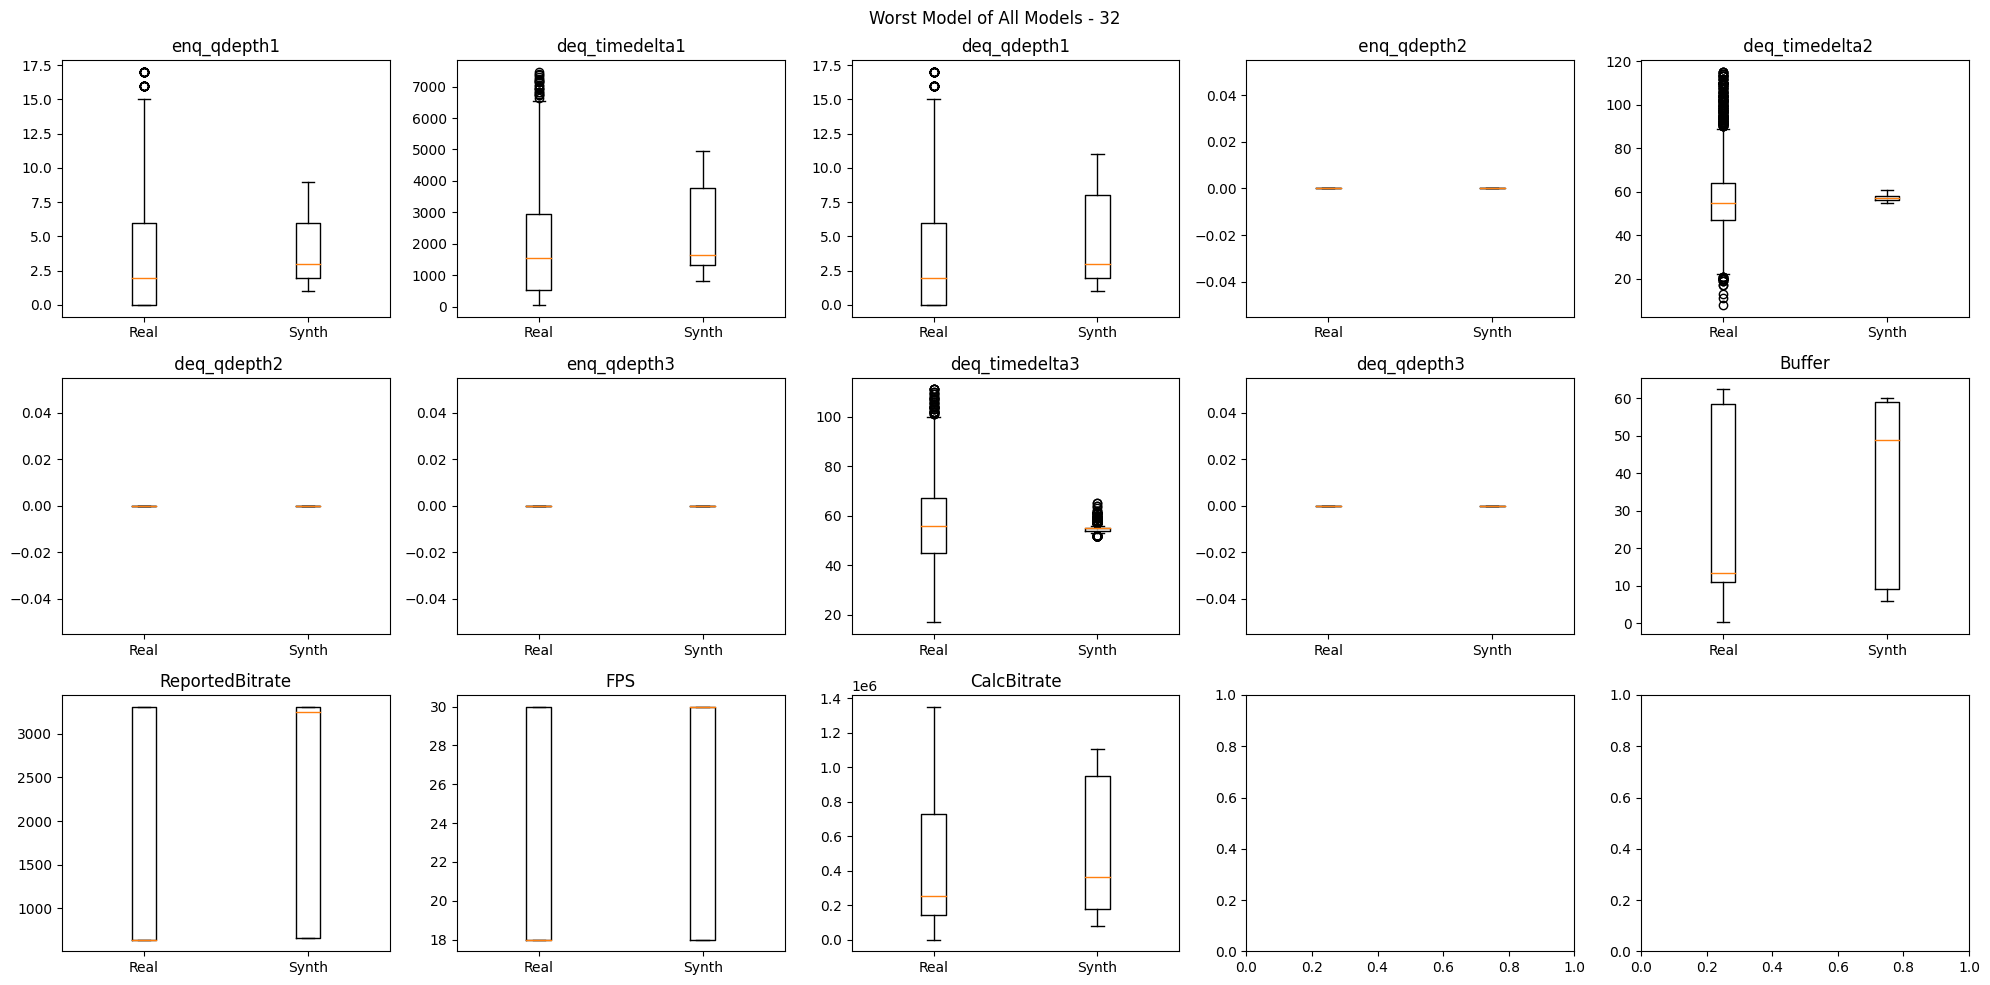

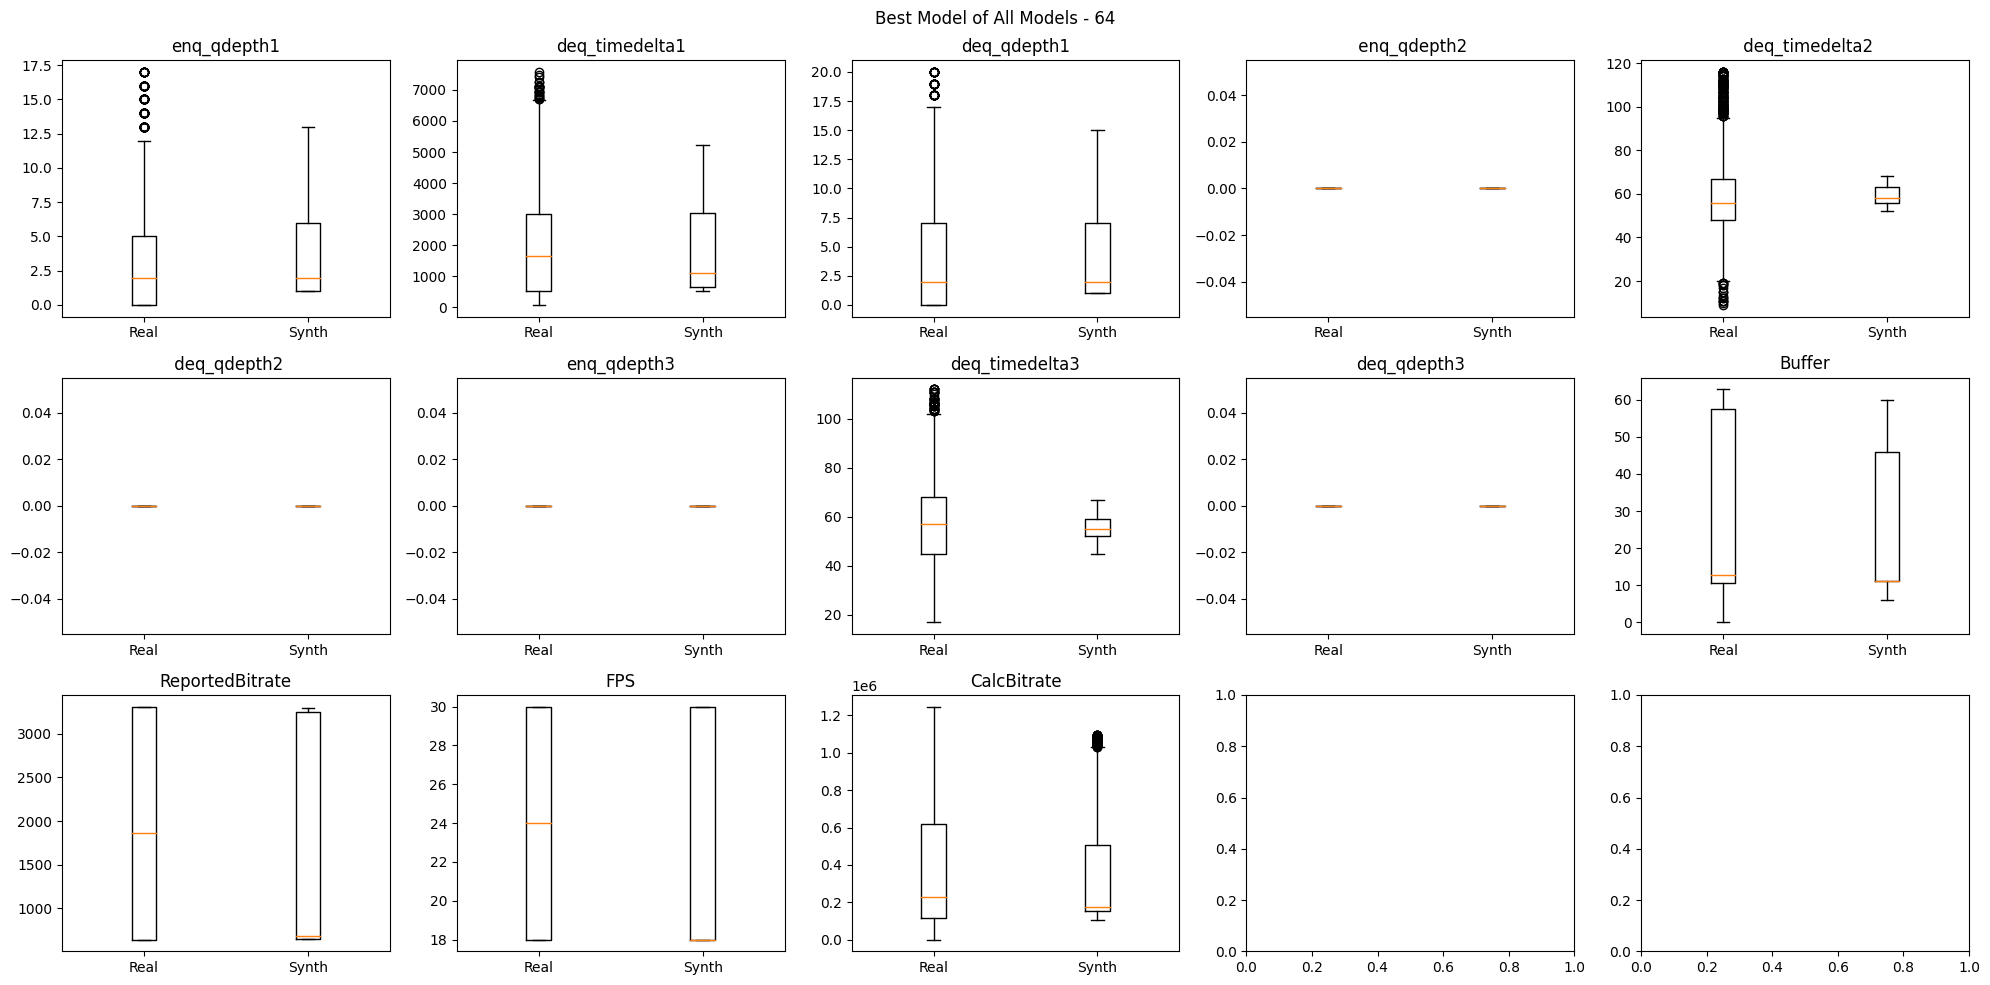

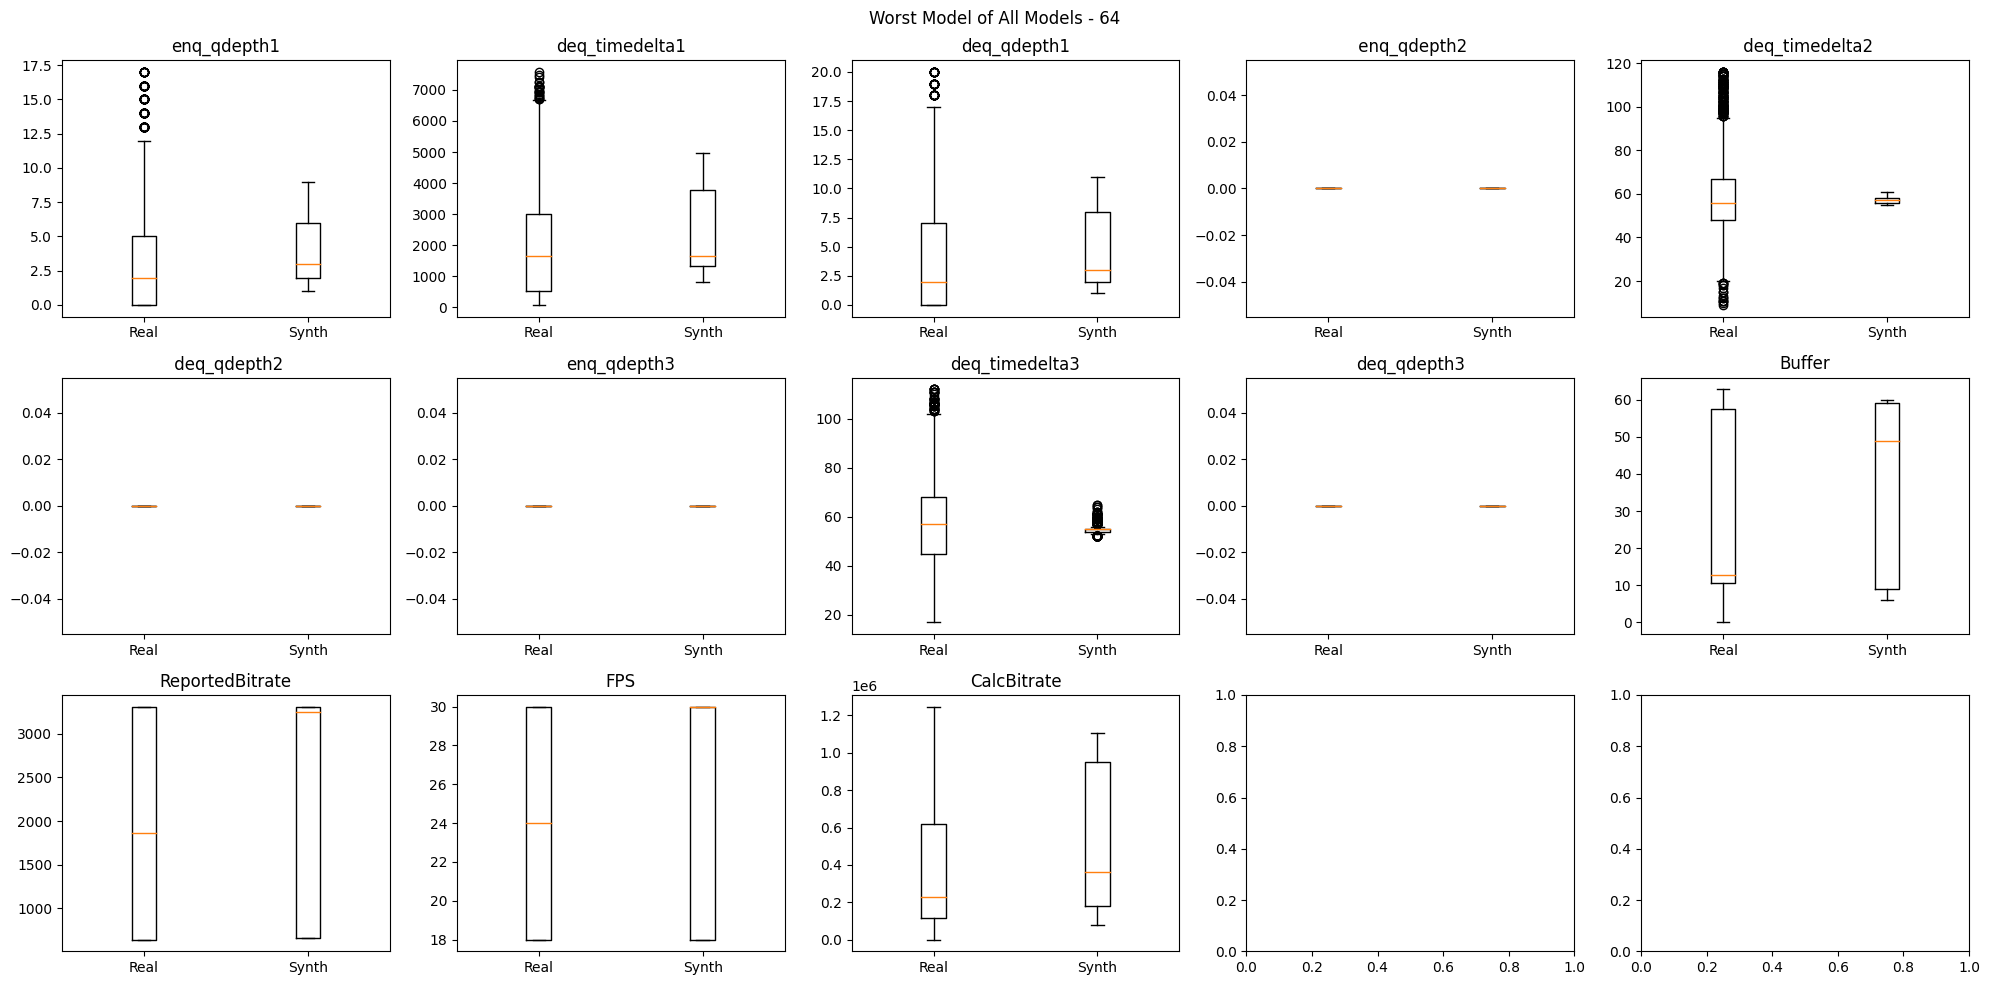

In [11]:
genBoxPlotAllFeatures(models_obj, 'Best Model of All Models - 32', real_32, best_modelsum_32, sample_size, num_cols, save=True, file_name='32_best_model_sum')
genBoxPlotAllFeatures(models_obj, 'Worst Model of All Models - 32', real_32, worst_modelsum_32, sample_size, num_cols, save=True, file_name='32_worst_model_sum')
genBoxPlotAllFeatures(models_obj, 'Best Model of All Models - 64', real_64, best_modelsum_64, sample_size, num_cols, save=True, file_name='64_best_model_sum')
genBoxPlotAllFeatures(models_obj, 'Worst Model of All Models - 64', real_64, worst_modelsum_64, sample_size, num_cols, save=True, file_name='64_worst_model_sum')


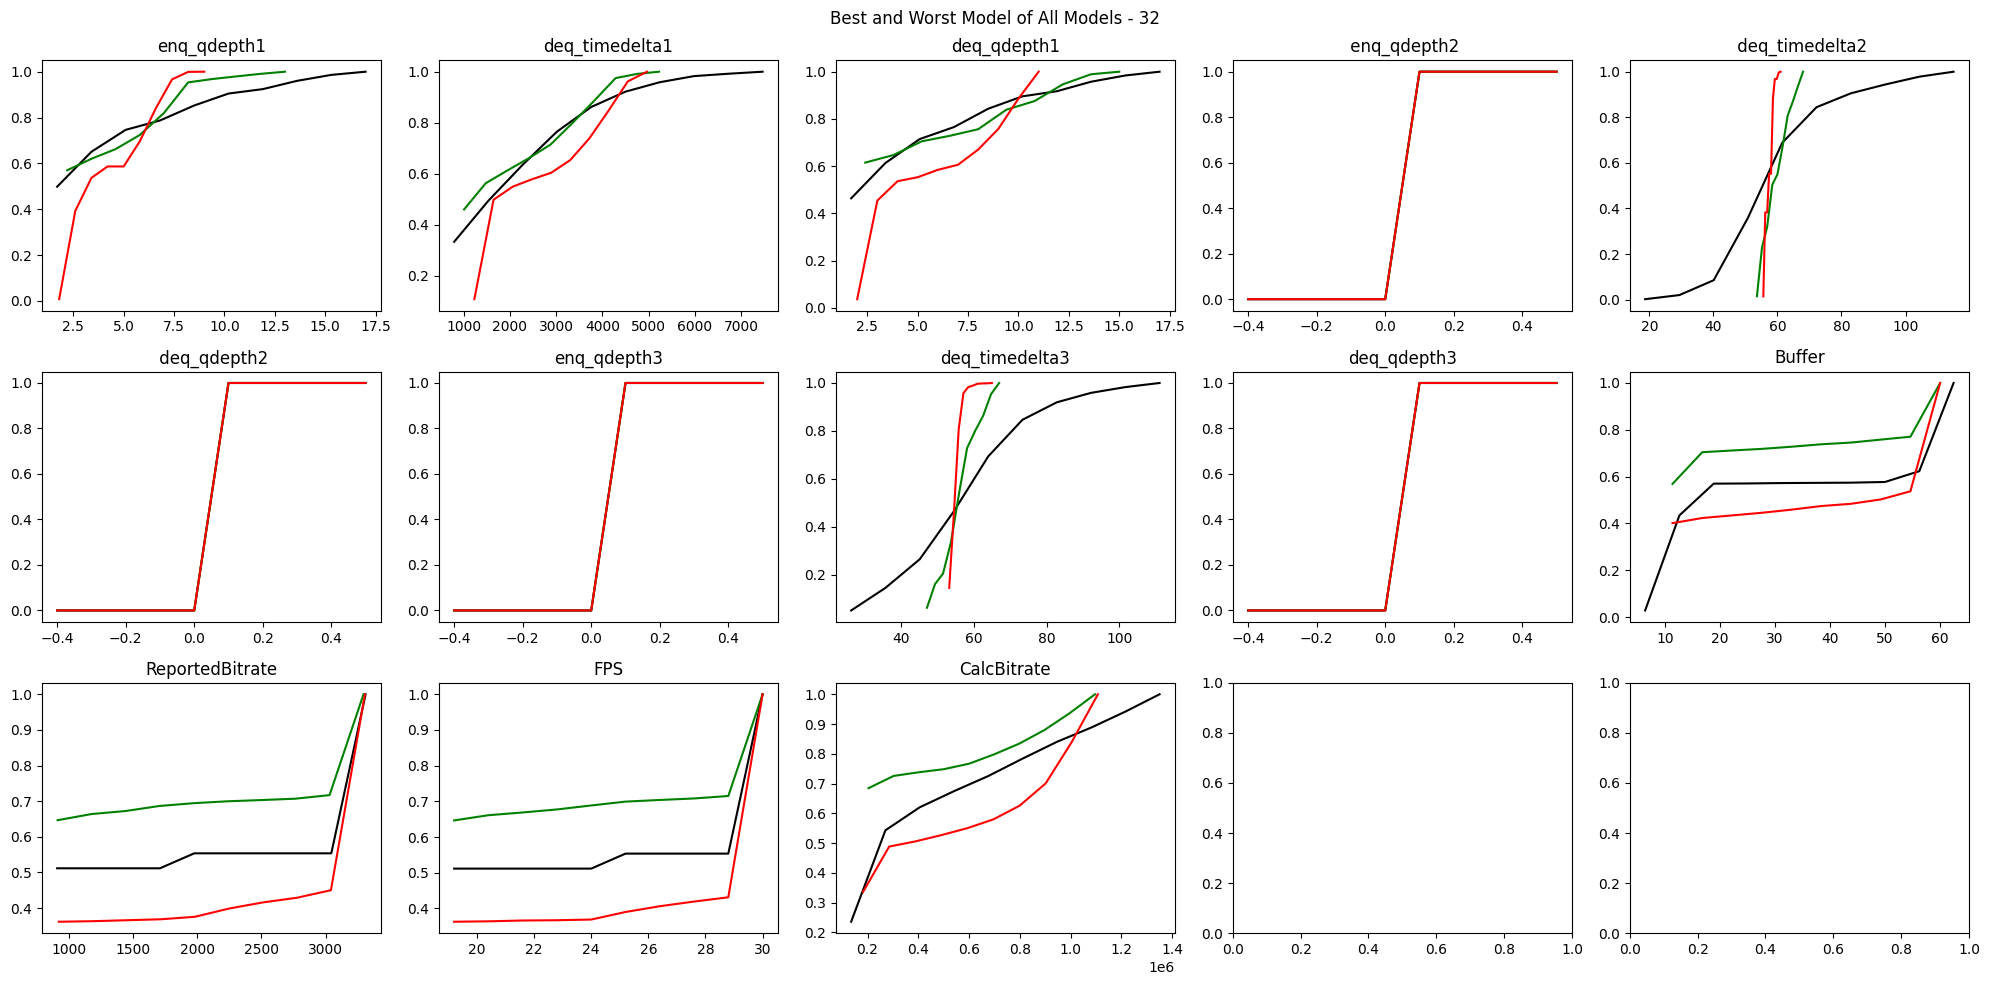

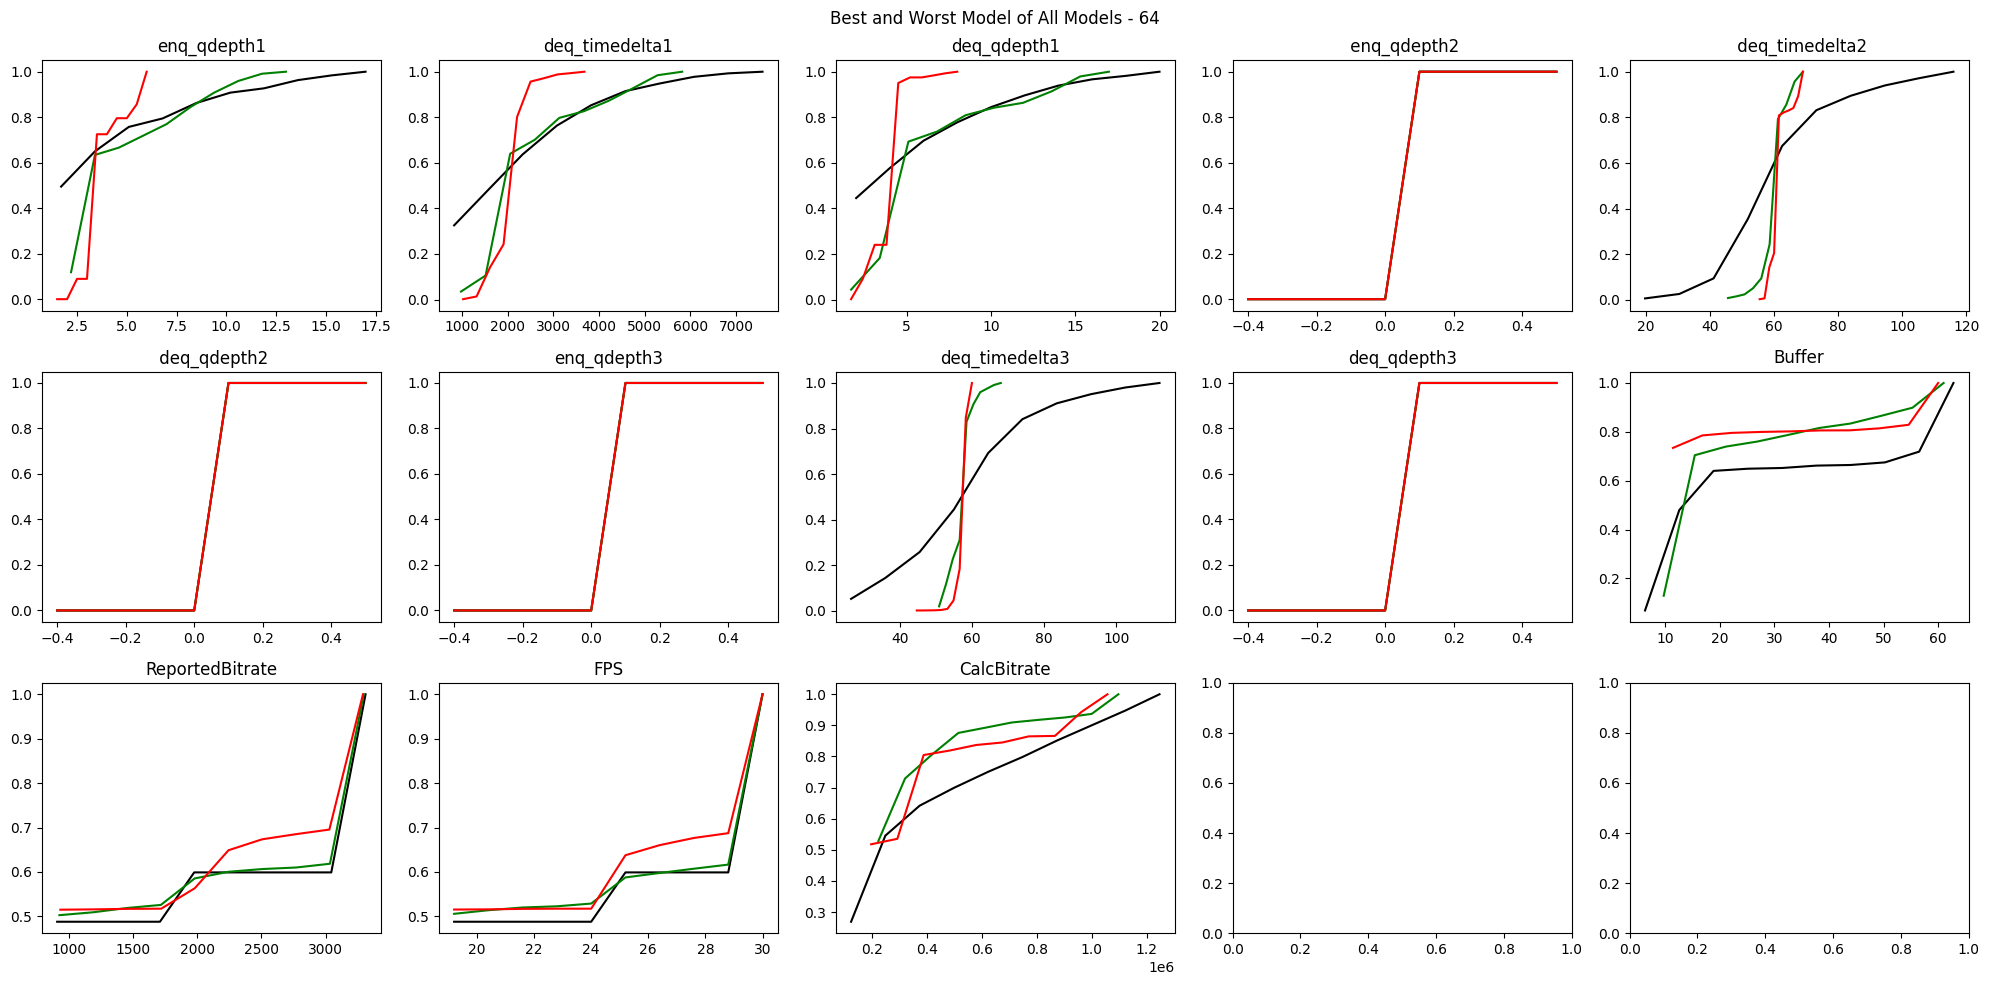

In [12]:
genBestWorstCDFAllFeatures(models_obj, 'Best and Worst Model of All Models - 32', real_32, best_modelsum_32, worst_modelsum_32, sample_size, num_cols, save=True, file_name='32_best_worst_modelsum')
genBestWorstCDFAllFeatures(models_obj, 'Best and Worst Model of All Models - 64', real_64, best_modelsum_64, worst_modelsum_64, sample_size, num_cols, save=True, file_name='64_best_worst_modelsum')

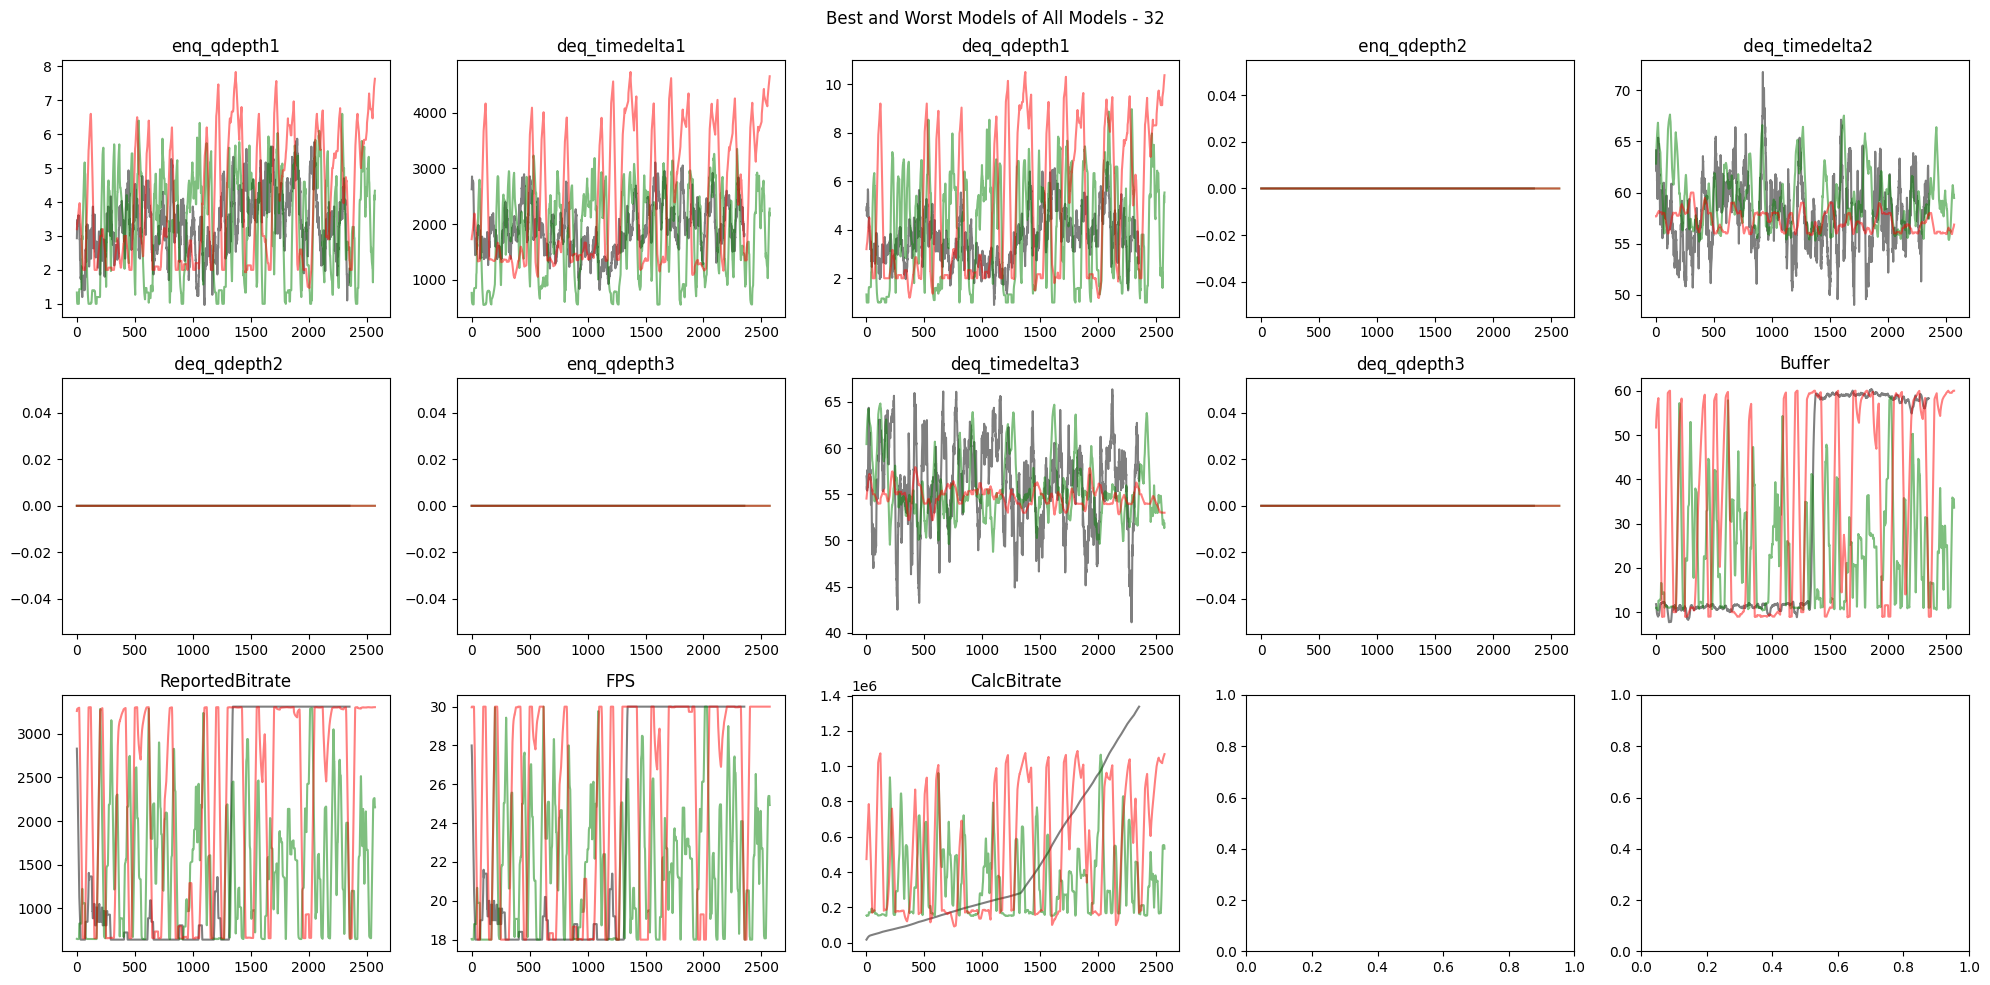

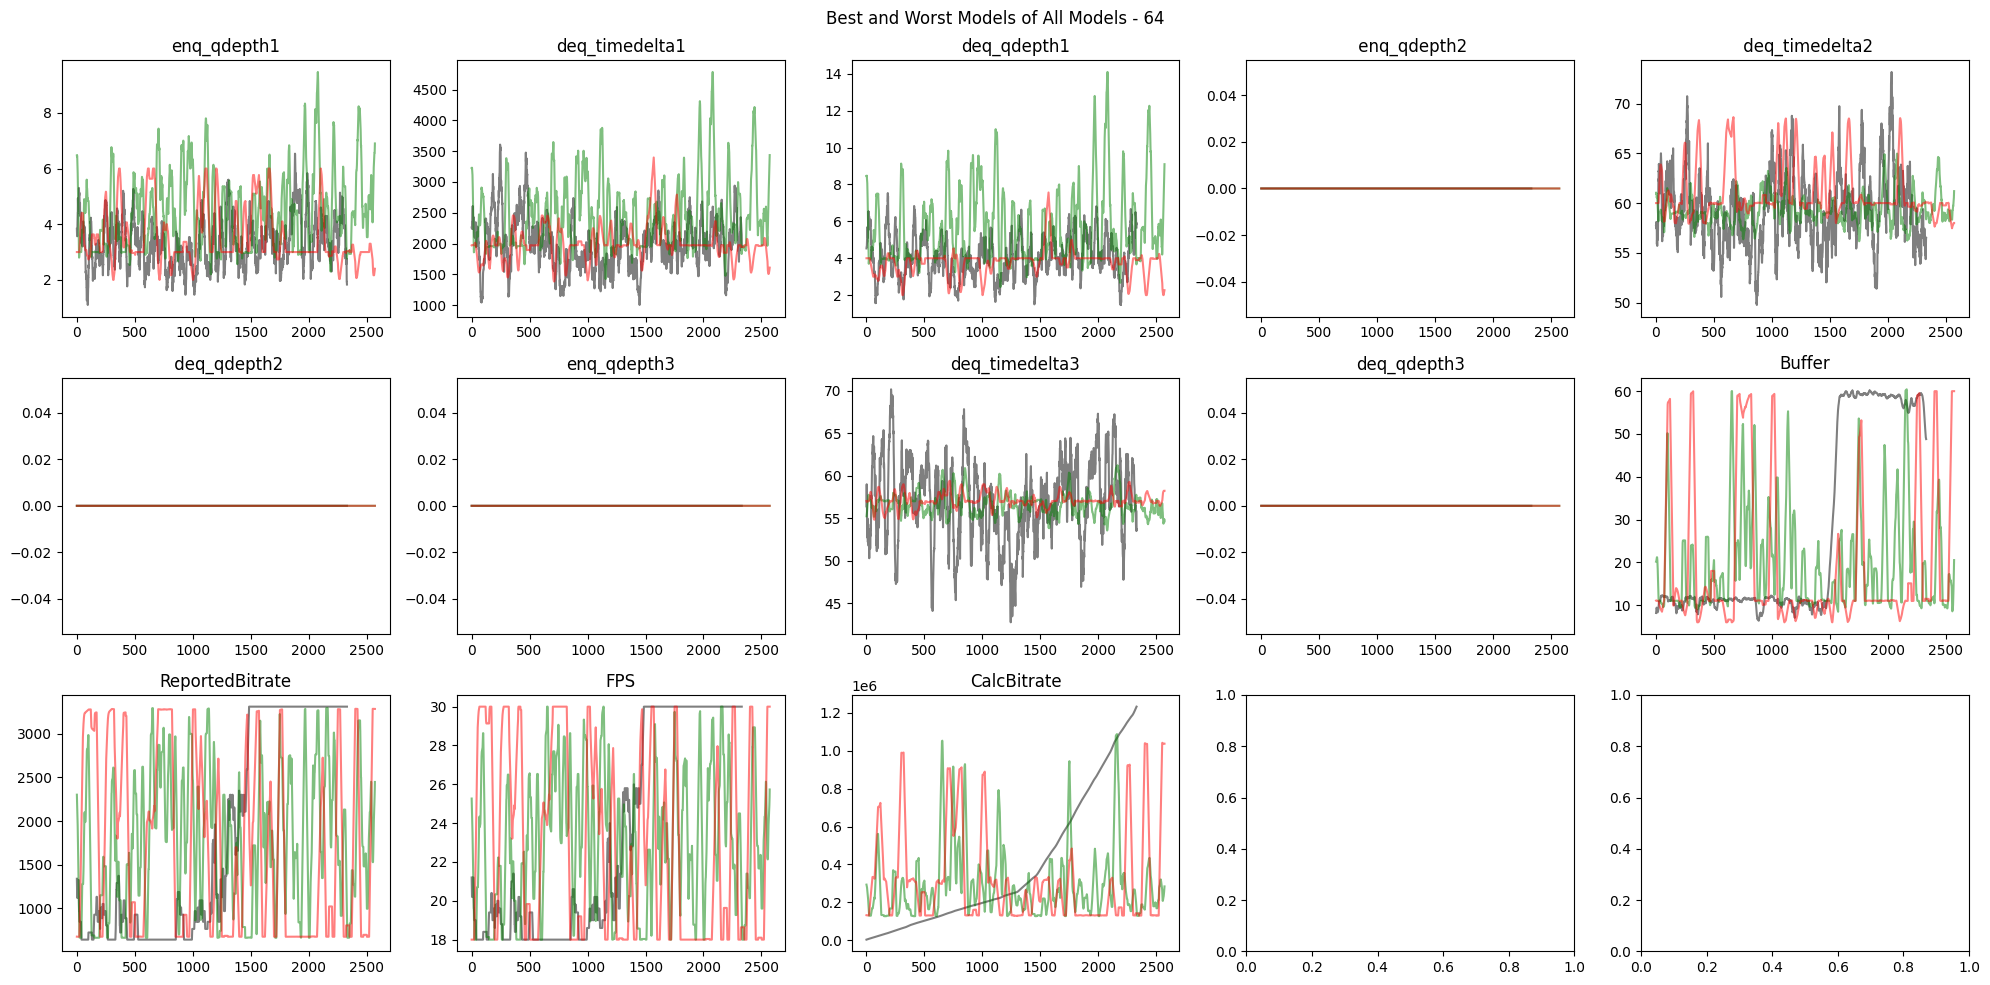

In [13]:
genEMAPlotAllFeatures(models_obj, 'Best and Worst Models of All Models - 32', real_32, best_modelsum_32, worst_modelsum_32, 30, sample_size, num_cols, save=True, file_name='32_best_models_sum')
genEMAPlotAllFeatures(models_obj, 'Best and Worst Models of All Models - 64', real_64, best_modelsum_64, worst_modelsum_64, 30, sample_size, num_cols, save=True, file_name='64_best_models_sum')

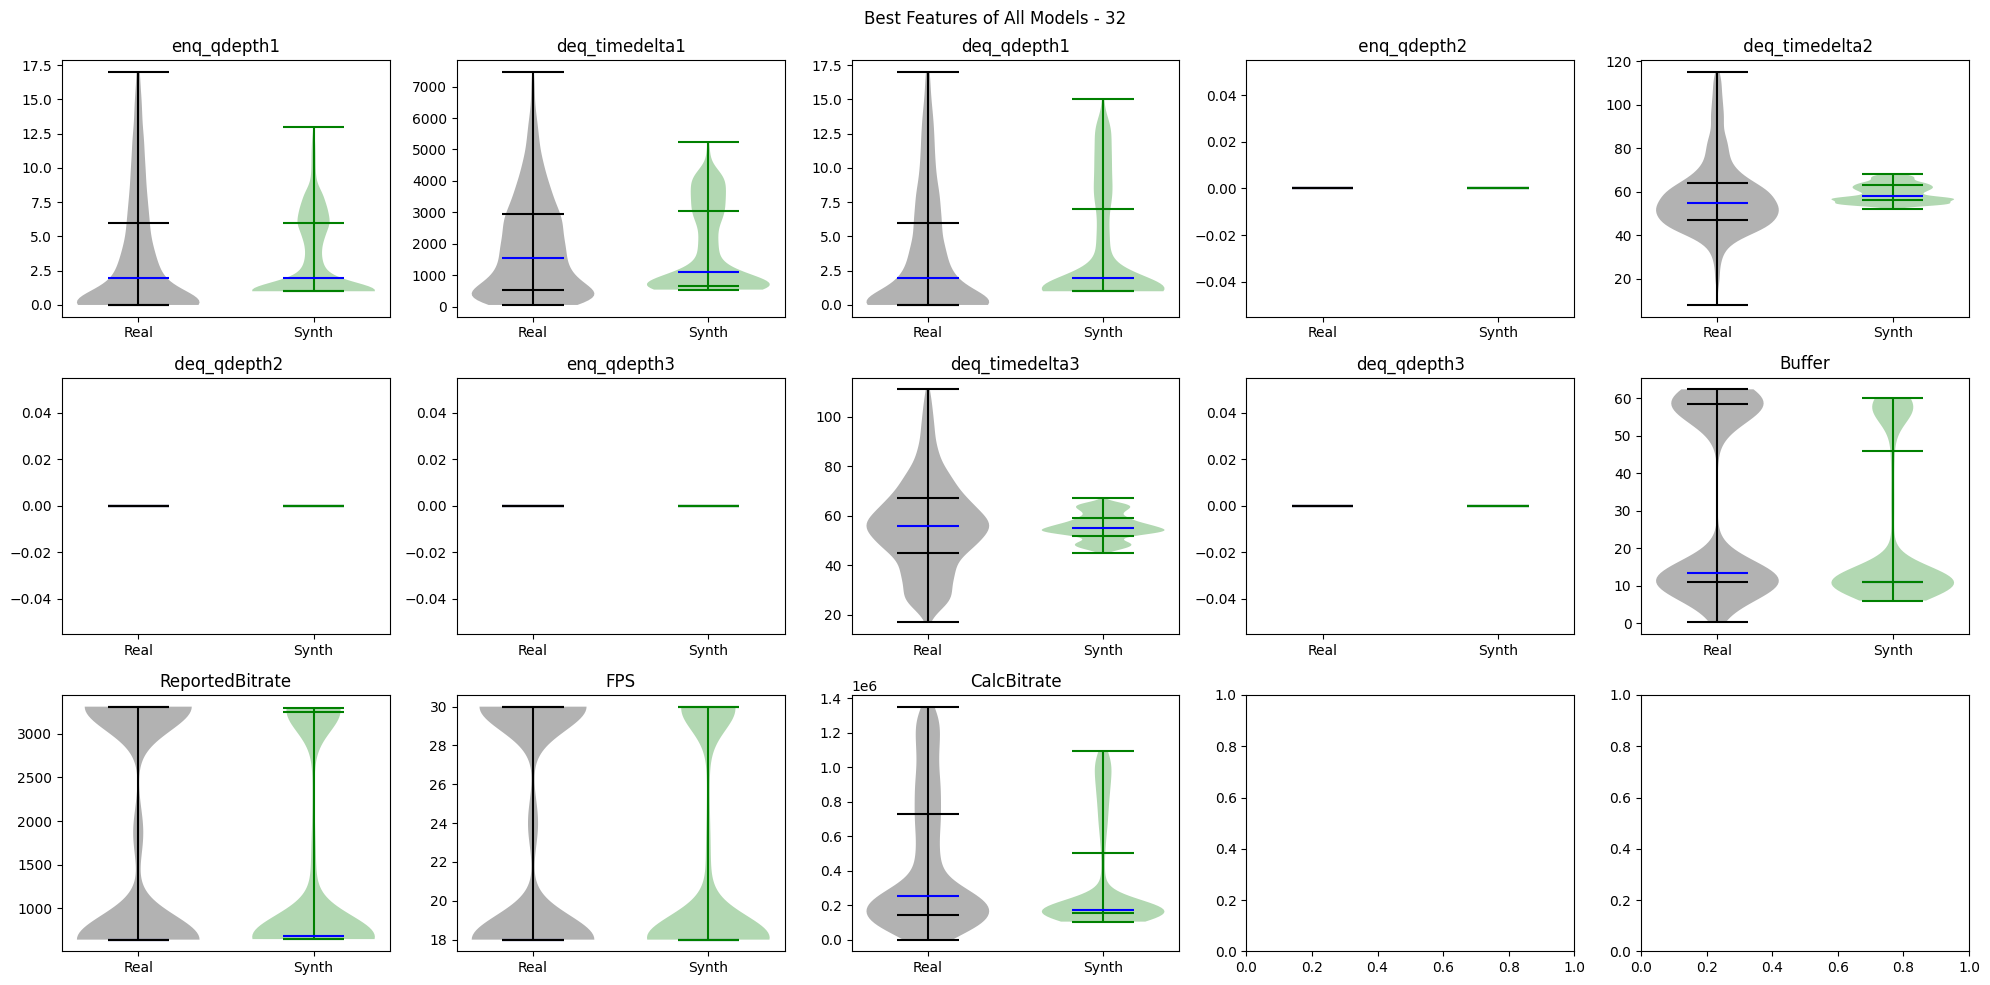

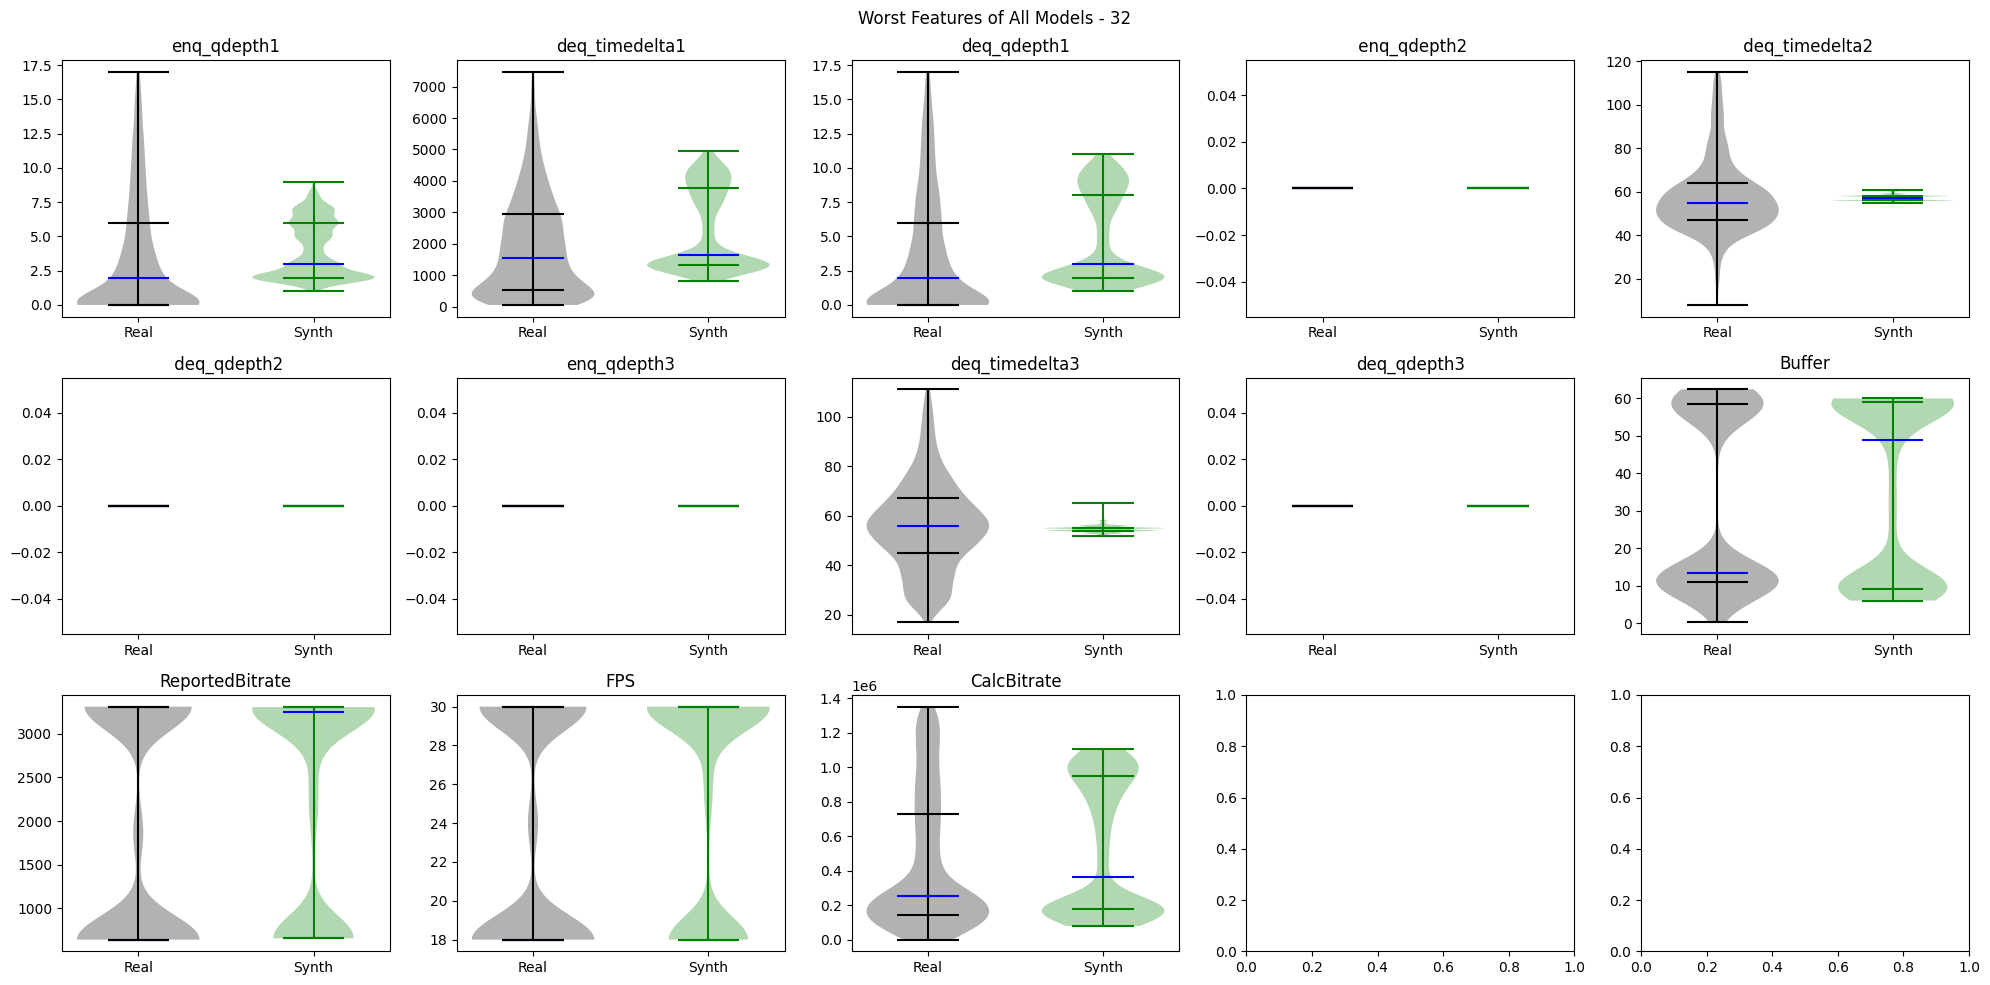

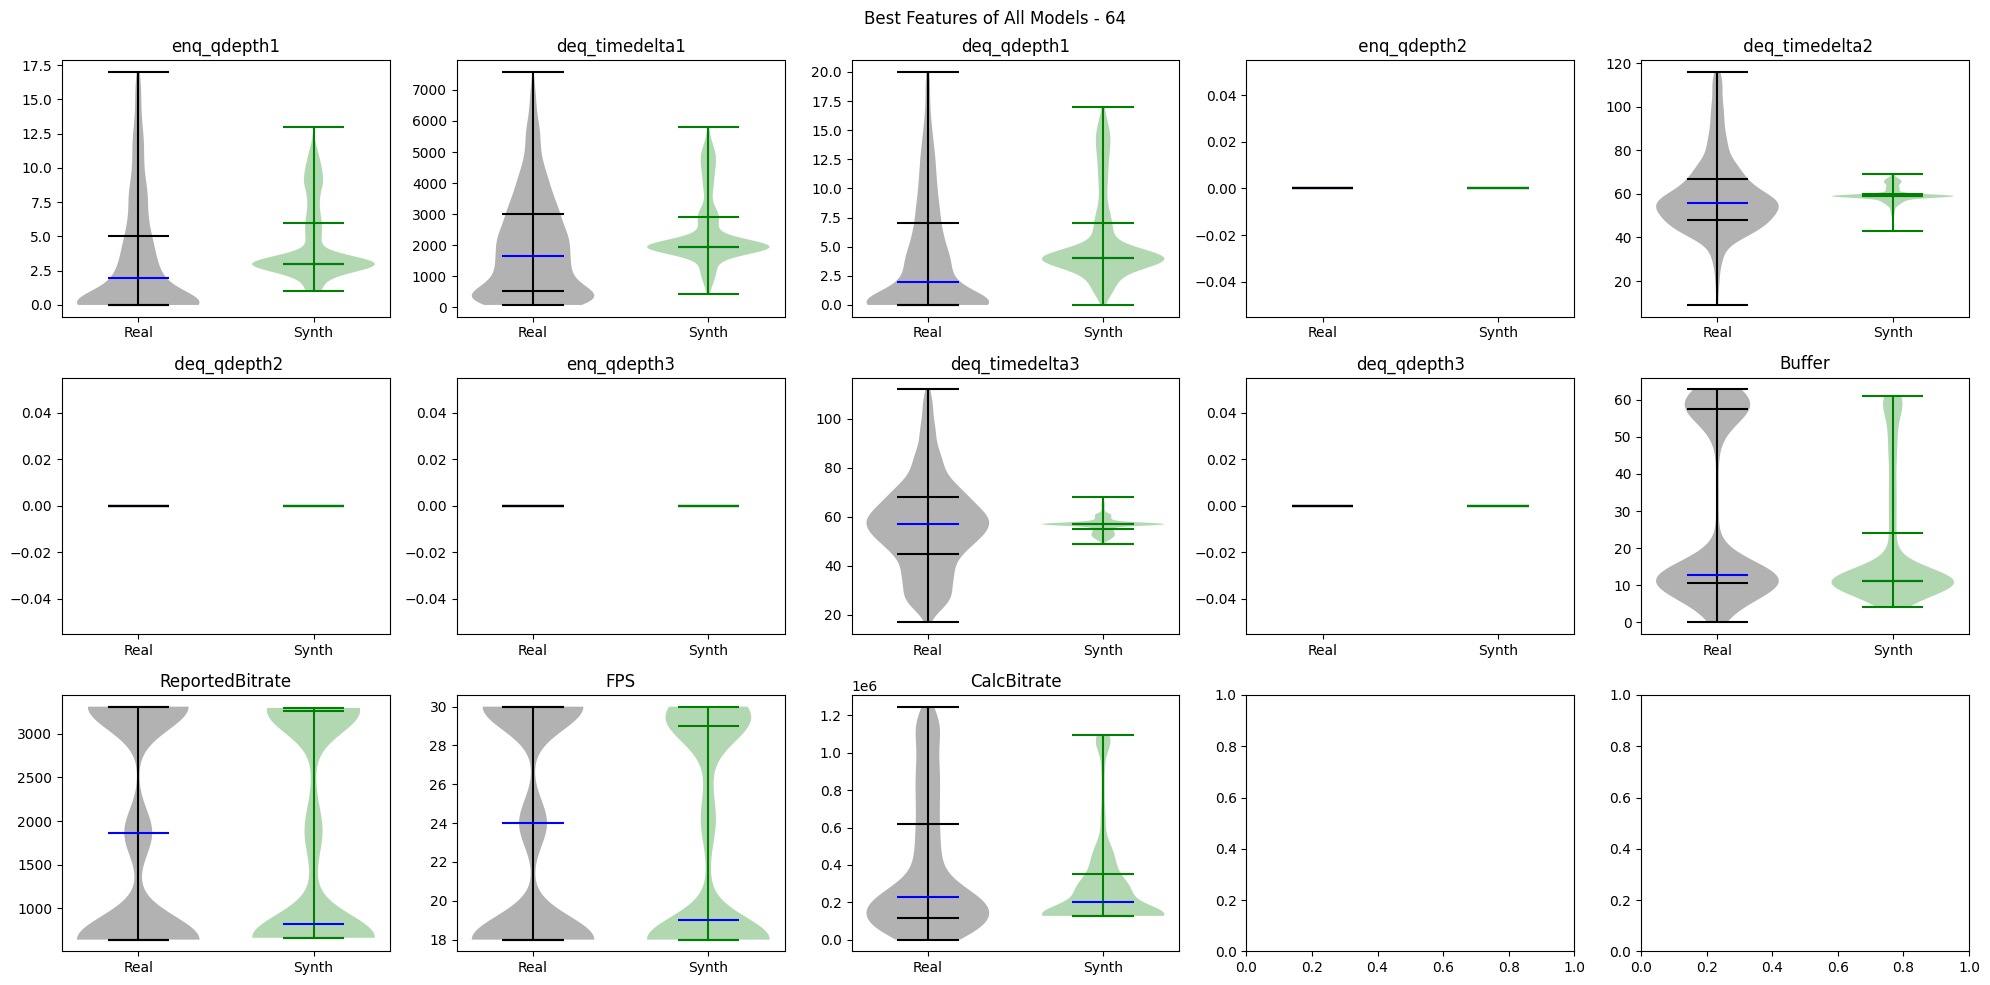

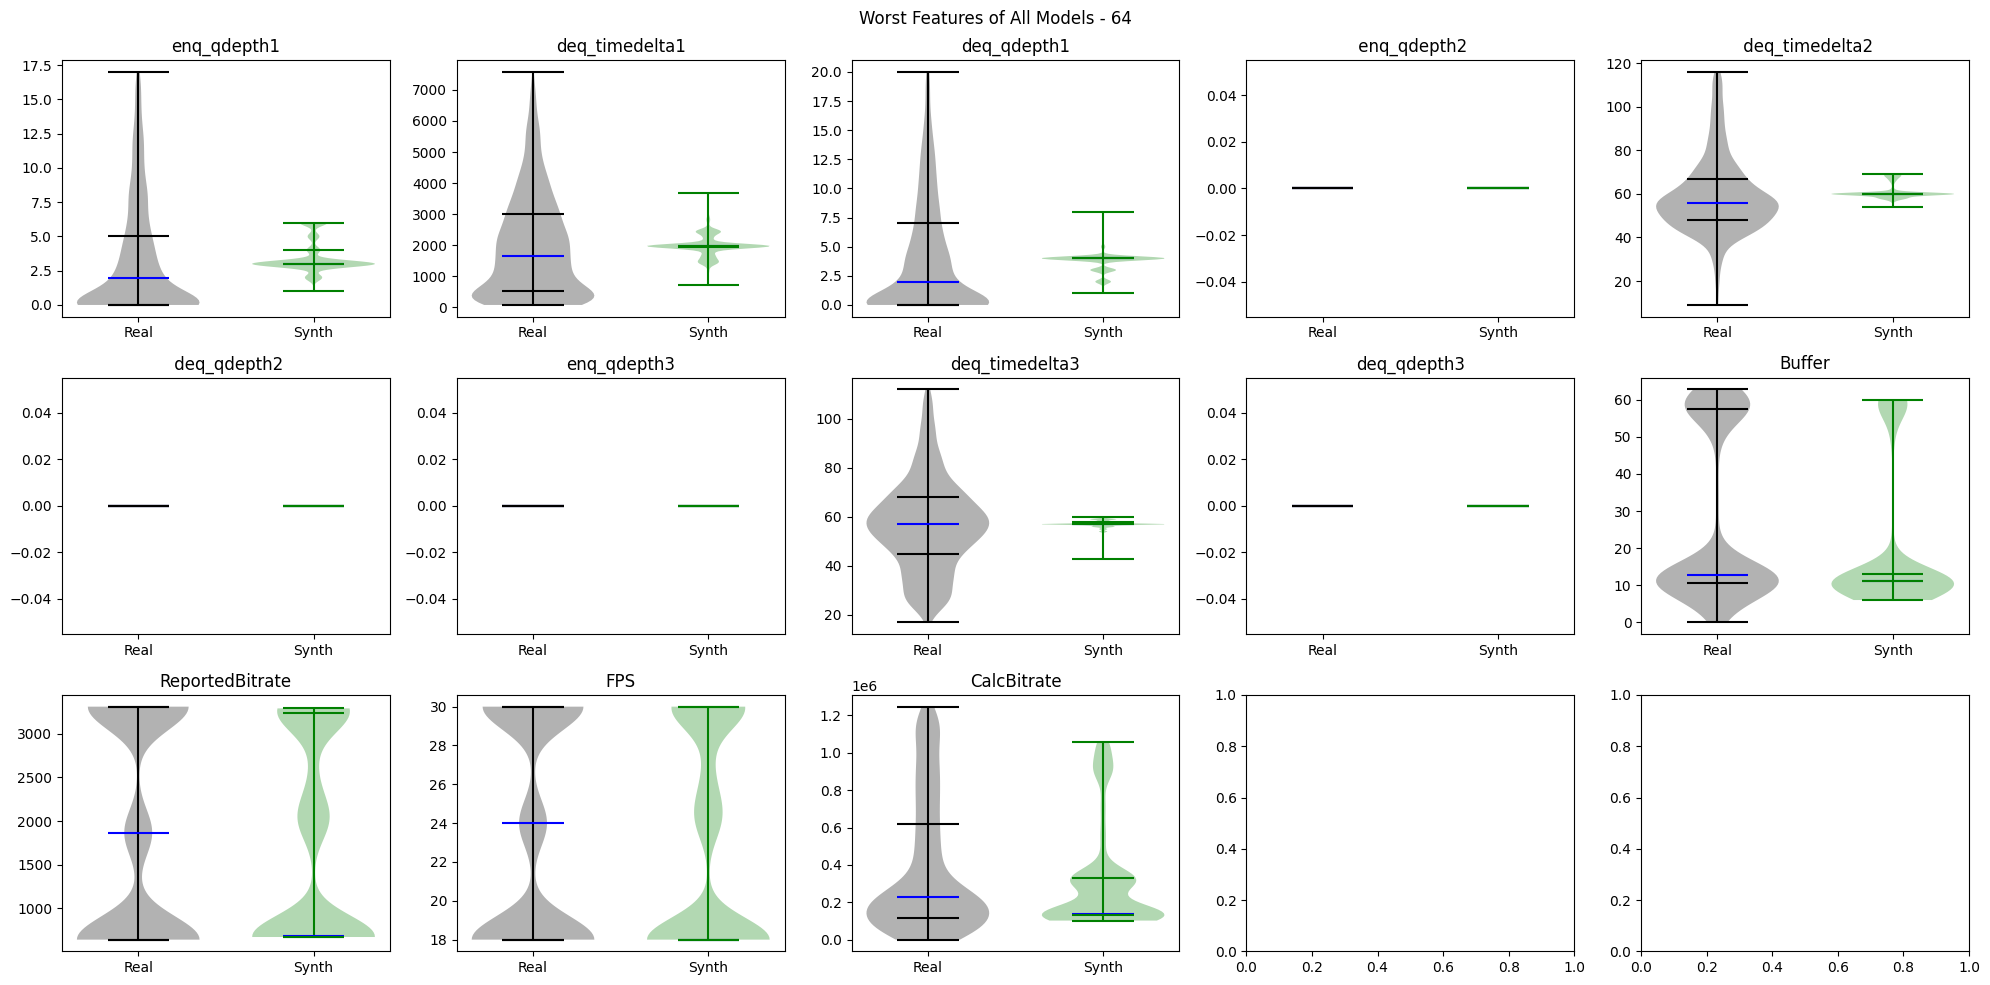

In [14]:
genViolinAllFeatures(models_obj, 'Best Features of All Models - 32', real_32, best_modelsum_32, sample_size, num_cols, save=True, file_name='32_best_models_sum')
genViolinAllFeatures(models_obj, 'Worst Features of All Models - 32', real_32, worst_modelsum_32, sample_size, num_cols, save=True, file_name='32_worst_models_sum')
genViolinAllFeatures(models_obj, 'Best Features of All Models - 64', real_64, best_modelsum_64, sample_size, num_cols, save=True, file_name='64_best_models_sum')
genViolinAllFeatures(models_obj, 'Worst Features of All Models - 64', real_64, worst_modelsum_64, sample_size, num_cols, save=True, file_name='64_worst_models_sum')

############ SAVE GRAPHS AND PLOTS ############

In [48]:
genBestWorstCDFSeparate(models_obj, 'best_worst_model_sum', real_32, best_modelsum_32, worst_modelsum_32, sample_size, num_cols, clas=32, save=True, show=False)
genBestWorstCDFSeparate(models_obj, 'best_worst_model_sum', real_64, best_modelsum_64, worst_modelsum_64, sample_size, num_cols, clas=64, save=True, show=False)

In [49]:
genBestWorstEMASeparate(models_obj, 'best_worst_model_sum', real_32, best_modelsum_32, worst_modelsum_32, 30, sample_size, num_cols, clas=32, save=True, show=False)
genBestWorstEMASeparate(models_obj, 'best_worst_model_sum', real_64, best_modelsum_64, worst_modelsum_64, 30, sample_size, num_cols, clas=64, save=True, show=False)

In [17]:
genViolinBestWorstSeparate32_64(models_obj, 'best_worst_model_sum', real_32, best_modelsum_32, worst_modelsum_32, 32, sample_size, num_cols, save=True, show=False)
genViolinBestWorstSeparate32_64(models_obj, 'best_worst_model_sum', real_64, best_modelsum_64, worst_modelsum_64, 64, sample_size, num_cols, save=True, show=False)

In [51]:
genBoxPlotModelsSeparate(models_obj, 'best_model_sum', real_32, best_modelsum_32, real_64, best_modelsum_64, sample_size, num_cols, save=True, show=False)

In [19]:
ds_best_modelsum_32 = createSaveDataSetModel(models_obj, 'best_modelsum_32', best_modelsum_32, num_cols, True)
ds_best_modelsum_64 = createSaveDataSetModel(models_obj, 'best_modelsum_64', best_modelsum_64, num_cols, True)
ds_worst_modelsum_32 = createSaveDataSetModel(models_obj, 'worst_modelsum_32', worst_modelsum_32, num_cols, True)
ds_worst_modelsum_64 = createSaveDataSetModel(models_obj, 'worst_modelsum_64', worst_modelsum_64, num_cols, True)

In [17]:
ds_real_32 = createRealDataSet(models_obj, 'real_32', real_32, num_cols)
ds_real_64 = createRealDataSet(models_obj, 'real_64', real_64, num_cols)

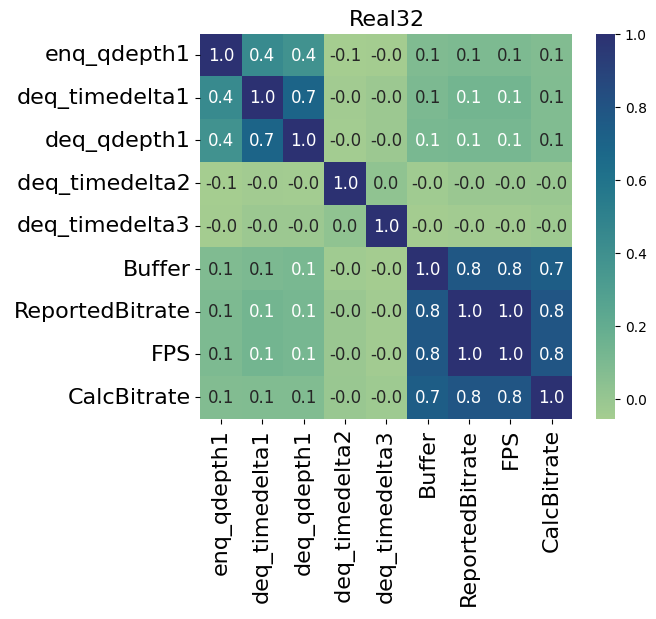

NameError: name 'ds_best_modelsum_32' is not defined

In [18]:
createCorrelationMatrix(models_obj, 'real32', 'Real32', ds_real_32 , 32, save=True)
createCorrelationMatrix(models_obj, 'bestmodel32', 'Best32', ds_best_modelsum_32, 32, save=True)
createCorrelationMatrix(models_obj, 'real64', 'Real64', ds_real_64, 64, save=True)
createCorrelationMatrix(models_obj, 'bestmodel64', 'Best64', ds_best_modelsum_64, 64, save=True)

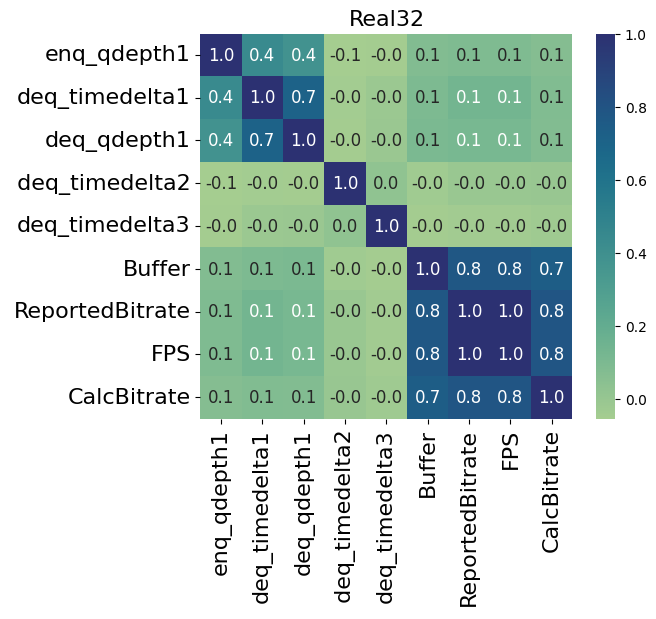

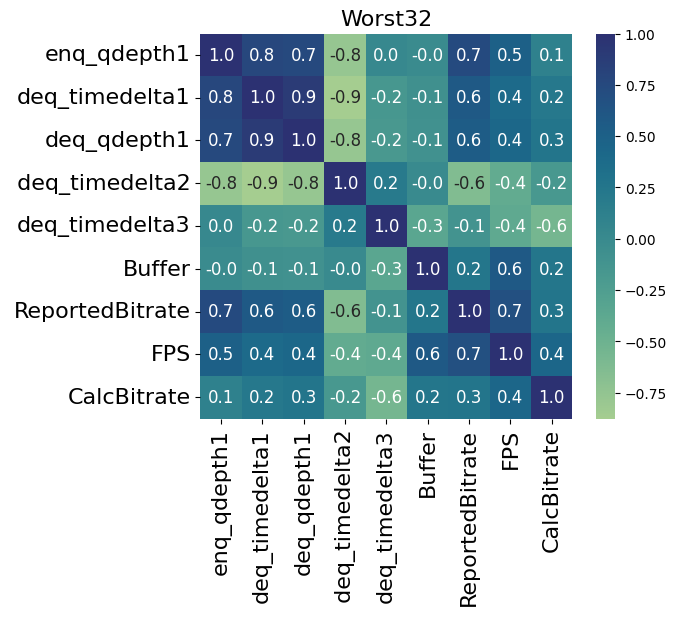

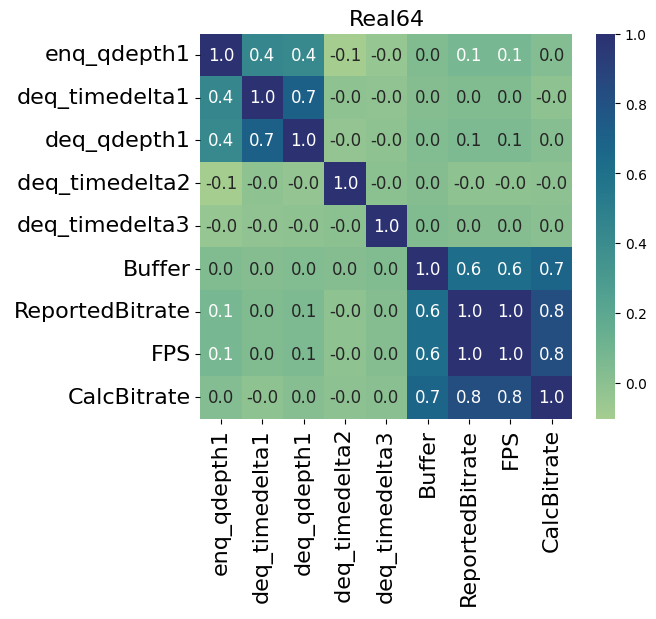

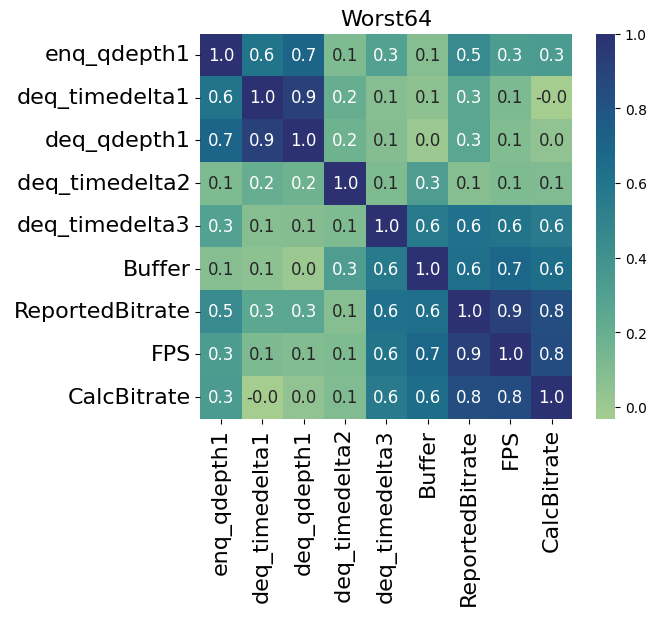

In [55]:
createCorrelationMatrix(models_obj, 'real32', 'Real32', ds_real_32 , 32, save=True)
createCorrelationMatrix(models_obj, 'worstmodel32', 'Worst32', ds_worst_modelsum_32, 32, save=True)
createCorrelationMatrix(models_obj, 'real64' , 'Real64',  ds_real_64, 64, save=True)
createCorrelationMatrix(models_obj, 'worstmodel64', 'Worst64', ds_worst_modelsum_64, 64, save=True)